In [ ]:
# CAREFUL: This removes ALL CSV, XLSX, and Parquet files
# Clean up ALL data files
import os
import glob

# Remove all CSV, XLSX, and Parquet files
for pattern in ['*.csv', '*.xlsx', '*.parquet']:
    files = glob.glob(pattern)
    for f in files:
        print(f"Removing: {f}")
        os.remove(f)

print("\n✓ Cleanup complete!")

# Check what's left
print("\nRemaining files:")
print(os.listdir())

# Upload training dataset
from google.colab import files
uploaded = files.upload()  # Upload 'training_dataset_6000.csv'


✓ Cleanup complete!

Remaining files:
['.config', 'beto-nova-final', 'cv_fold_0', 'cv_fold_4', 'cross_validation_results.png', 'validation_vs_test_performance.png', 'beto-nova-best', 'uncertainty_distribution.png', 'test_set_confusion_matrix.png', 'cv_fold_1', 'validation_confusion_matrix_final.png', 'reliability_diagram.png', 'cv_results.json', 'cv_fold_2', 'cv_fold_3', 'TEST_SET_FINAL_SUMMARY.json', 'sample_data']


Saving training_dataset_6000.csv to training_dataset_6000.csv


In [ ]:
import torch
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

GPU available: True
GPU: NVIDIA L4


BETO FOOD CLASSIFICATION - WITH NOVA MARKERS PREPROCESSING

This version adds classification markers to help BERT learn NOVA patterns.
Markers are based on your labeling rules and domain knowledge.
Loading data from training_dataset_6000.csv...
✓ Successfully loaded 6000 samples
✓ All required columns present
✓ All NOVA values valid: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Dataset shape: (6000, 7)
Columns: ['id_gasto', 'folio', 'descripcion', 'establecimiento', 'ccif', 'NOVA', 'glosa']

=== Text Preprocessing with NOVA Classification Markers ===

Cleaning text fields...
Adding NOVA classification markers...
Creating combined text with markers...
✓ Text preprocessing with markers complete

=== Marker Statistics ===
Number of markers per item:
  0 markers: 5571 items (92.8%)
  1 markers: 426 items (7.1%)
  2 markers: 3 items (0.1%)

Most common markers:
  [RESTAURANT_DISH]: 113 times
  [FRESH_BREAD_NOVA3]: 94 times
  [COMPLETO_NOVA4]: 94 times
  [FAST_FOOD_NOVA

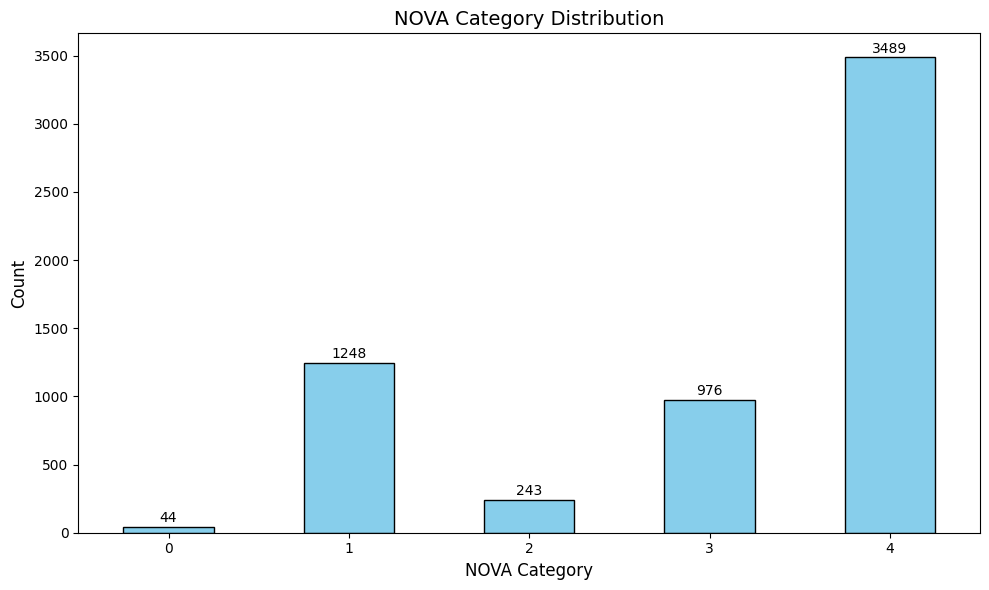


=== Marker Distribution by NOVA Category ===

[ARTISANAL_NOVA3]:
  ✓ NOVA 3: 2 items (100.0% of this marker)
  📊 Alignment Score: 100.0% (higher is better)


[COFFEE_MILK_NOVA4]:
  ✓ NOVA 4: 25 items (100.0% of this marker)
  📊 Alignment Score: 100.0% (higher is better)


[COLACION_TRADITIONAL_NOVA3]:
  ✓ NOVA 3: 12 items (100.0% of this marker)
  📊 Alignment Score: 100.0% (higher is better)


[COMPLETO_NOVA4]:
  ✓ NOVA 4: 94 items (100.0% of this marker)
  📊 Alignment Score: 100.0% (higher is better)


[FAST_FOOD_NOVA4]:
  ✓ NOVA 4: 56 items (100.0% of this marker)
  📊 Alignment Score: 100.0% (higher is better)


[FRESH_BREAD_NOVA3]:
  ✓ NOVA 3: 94 items (100.0% of this marker)
  📊 Alignment Score: 100.0% (higher is better)


[NON_FOOD_NOVA0]:
  ⚠️ NOVA 0: 30 items (100.0% of this marker)


[RESTAURANT_DISH]:
  ⚠️ NOVA 3: 86 items (76.1% of this marker)
  ⚠️ NOVA 4: 27 items (23.9% of this marker)


[TRADITIONAL_DRINK_NOVA3]:
  ✓ NOVA 3: 6 items (100.0% of this marker)
  📊 Alignment 

In [ ]:
# BETO Food Classification Pipeline - WITH CLASSIFICATION MARKERS VERSION
# Text preprocessing with domain-specific markers for NOVA classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

# ==============================================================================
# DATA LOADING AND VALIDATION FUNCTIONS
# ==============================================================================
def load_and_validate_data(filepath):
    """
    Load data and perform basic validation checks
    """
    print(f"Loading data from {filepath}...")

    try:
        df = pd.read_csv(filepath)
        print(f"✓ Successfully loaded {len(df)} samples")
    except Exception as e:
        print(f"✗ Error loading file: {e}")
        return None

    # Check required columns
    required_cols = ['descripcion', 'establecimiento', 'NOVA']
    missing_cols = set(required_cols) - set(df.columns)
    if missing_cols:
        print(f"✗ Missing required columns: {missing_cols}")
        return None
    else:
        print(f"✓ All required columns present")

    # Check for nulls in critical columns
    null_counts = df[required_cols].isnull().sum()
    if null_counts.any():
        print("\n⚠️  Warning: Found null values:")
        print(null_counts[null_counts > 0])

    # Validate NOVA values
    valid_nova = {0, 1, 2, 3, 4}
    valid_nova = {0, 1, 2, 3, 4}
    unique_nova = set(df['NOVA'].dropna().unique())
    invalid_nova = unique_nova - valid_nova
    if invalid_nova:
        print(f"✗ Invalid NOVA values found: {invalid_nova}")
        return None
    else:
        print(f"✓ All NOVA values valid: {sorted(unique_nova)}")

    # Check for duplicates based on id_gasto if it exists
    if 'id_gasto' in df.columns:
        duplicates = df['id_gasto'].duplicated().sum()
        if duplicates > 0:
            print(f"⚠️  Warning: Found {duplicates} duplicate id_gasto entries")

    return df

# ==============================================================================
# TEXT PREPROCESSING FUNCTIONS
# ==============================================================================
def clean_text(text):
    """
    Basic text cleaning while preserving Spanish characters
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Remove extra whitespaces
    text = ' '.join(text.split())

    # Keep letters, numbers, spaces, and common Spanish characters
    # Don't remove accents or ñ as they're important in Spanish
    text = re.sub(r'[^\w\sáéíóúñü\-\.]', ' ', text)

    # Remove extra spaces again
    text = ' '.join(text.split())

    return text

# ==============================================================================
# NOVA CLASSIFICATION MARKERS - CORRECTED VERSION
# ==============================================================================
def add_nova_markers(descripcion, establecimiento):
    """
    MINIMAL MARKERS - Only the most reliable classification signals
    CORRECTED VERSION with proper NOVA 0 handling
    """
    markers = []
    desc_clean = clean_text(descripcion)
    est_clean = clean_text(establecimiento)

# 0. NON-FOOD ITEMS - NOVA 0 marker (ULTRA-CONSERVATIVE + REFINED)
# Only mark as NOVA 0 if we're ABSOLUTELY CERTAIN it's not food

    # PROPINA - only if it's clearly just the tip
    if (desc_clean == 'propina' or
      desc_clean.startswith('propina restaurant') or
      desc_clean.startswith('propina bar') or
      desc_clean.startswith('propina en servicio') or
      desc_clean.startswith('propina cafe')) and \
      not any(food in desc_clean for food in ['almuerzo', 'comida', 'sandwich', 'cafe', 'bebida']):
      markers.append('[NON_FOOD_NOVA0]')
      return markers

# EXCLUDE CUOTA if it contains food/meal references
    if 'cuota' in desc_clean and not any(food_term in desc_clean for food_term in
      ['almuerzo', 'comida', 'pollo', 'carne', 'bebida', 'cuenta compartida', 'menu', 'plato']):
      markers.append('[NON_FOOD_NOVA0]')
      return markers

# Other non-food items - use exact phrases to avoid false positives
    nova0_phrases = [
    'diferencia ticket',
    'diferencia boleta',
    'ticket de casino',
    'celebracion cumpleaños',
    'celebración cumpleaños',
    'decoracion fiesta',
    'pañales bebe',
    'bolsa plastica',
    'entrada cine',
    'ticket estacionamiento',
    'ticket diferencia'
    ]

    if any(phrase in desc_clean for phrase in nova0_phrases):
        markers.append('[NON_FOOD_NOVA0]')
        return markers

    if any(phrase in desc_clean for phrase in nova0_phrases):
        markers.append('[NON_FOOD_NOVA0]')
        return markers

    # 1. COMPLETO - More specific for hot dog, not "complete meal"
    if 'completo' in desc_clean and \
       not any(menu_word in desc_clean for menu_word in ['menu', 'plato', 'entrada', 'fondo', 'ensalada']):
        markers.append('[COMPLETO_NOVA4]')

    # 2. COFFEE WITH MILK - NOVA 4
    if any(coffee_milk in desc_clean for coffee_milk in ['cafe cortado', 'cafe con leche', 'cappuccino', 'capuccino', 'latte', 'mocha', 'frappuccino']):
        markers.append('[COFFEE_MILK_NOVA4]')

    # 3. FAST FOOD CHAINS - NOVA 4 (but exclude simple coffee/tea)
    if any(chain in est_clean for chain in ['mc donalds', 'mcdonald', 'kfc', 'burger king', 'subway', 'doggis']) and \
       not any(simple_drink in desc_clean for simple_drink in ['cafe', 'te']):
        markers.append('[FAST_FOOD_NOVA4]')


  # 4. FRESH BREAD - NOVA 3 marker (FINAL VERSION)
    if any(bread in desc_clean for bread in ['marraqueta', 'hallulla', 'pan amasado', 'pan italiano', 'pan frances', 'pan francés', 'pan corriente', 'amasado', 'dobladita', 'dobladitas', 'especial']) and \
      any(venue in est_clean for venue in ['almacen', 'panaderia', 'panadería', 'particular', 'calle', 'cafeteria', 'supermercado', 'comercial', 'negocio', 'lider']) and \
      not any(industrial in desc_clean for industrial in ['hamburguesa','blan','rayado','rallado','panko','molde','multigrano', 'blanco','completo', 'precocida', 'precocido', 'precosidas', 'precosidos', 'pre cocida', 'envasado', 'envasadas', 'molde', 'hot dog', 'bolsa', 'bolsas', 'congelada', 'preparado', 'env', 'prehorneadas']):
        markers.append('[FRESH_BREAD_NOVA3]')

    # 5. ARTISANAL ICE CREAM - NOVA 3
    if 'helado' in desc_clean and 'artesanal' in desc_clean and 'heladeria' in est_clean:
      markers.append('[ARTISANAL_NOVA3]')

    # 6. TRADITIONAL CHILEAN DRINKS - NOVA 3
    if 'mote con huesillo' in desc_clean or 'mote co huesillo' in desc_clean:
      markers.append('[TRADITIONAL_DRINK_NOVA3]')

    # 7. Restaurant dishes - NOT NOVA 1 (let BERT choose between NOVA 3/4)
    if any(dish in desc_clean for dish in ['pollo', 'lomo', 'cerdo', 'vacuno', 'cazuela', 'tallarin', 'tallarines', 'seco', 'arroz', 'erizo']) and \
        any(rest in est_clean for rest in ['restaurant', 'restaurante', 'particular']):
        markers.append('[RESTAURANT_DISH]')

    # 8. COLACION WITH TRADITIONAL MEAL COMPONENTS - NOVA 3
    if 'colacion' in desc_clean and \
      ('plato de fondo' in desc_clean or 'plato principal' in desc_clean or
      ('plato + ensalada' in desc_clean)):
      markers.append('[COLACION_TRADITIONAL_NOVA3]')

    return markers

# ==============================================================================
# ENHANCED PREPROCESSING WITH MARKERS
# ==============================================================================
def preprocess_dataframe(df):
    """
    Apply text preprocessing WITH classification markers
    Markers help BERT learn NOVA patterns more effectively
    """
    print("\n=== Text Preprocessing with NOVA Classification Markers ===")

    # Create a copy
    df_processed = df.copy()

    # Clean text fields
    print("\nCleaning text fields...")
    df_processed['descripcion_clean'] = df_processed['descripcion'].apply(clean_text)
    df_processed['establecimiento_clean'] = df_processed['establecimiento'].apply(clean_text)

    # Add classification markers
    print("Adding NOVA classification markers...")
    df_processed['markers'] = df_processed.apply(
        lambda row: add_nova_markers(row['descripcion'], row['establecimiento']),
        axis=1
    )

    # Convert markers to string
    df_processed['markers_str'] = df_processed['markers'].apply(lambda x: ' '.join(x) if x else '')

    # Create combined text with markers
    print("Creating combined text with markers...")
    df_processed['combined_text'] = df_processed.apply(
        lambda row: f"{row['markers_str']} {row['descripcion_clean']} [SEP] {row['establecimiento_clean']}".strip(),
        axis=1
    )

    # Add text statistics for analysis
    df_processed['desc_length'] = df_processed['descripcion_clean'].str.len()
    df_processed['desc_words'] = df_processed['descripcion_clean'].str.split().str.len()
    df_processed['est_words'] = df_processed['establecimiento_clean'].str.split().str.len()
    df_processed['marker_count'] = df_processed['markers'].apply(len)
    df_processed['total_words'] = df_processed['desc_words'] + df_processed['est_words'] + df_processed['marker_count']

    print("✓ Text preprocessing with markers complete")

    # Show marker statistics
    print("\n=== Marker Statistics ===")
    marker_counts = df_processed['marker_count'].value_counts().sort_index()
    print("Number of markers per item:")
    for count, freq in marker_counts.items():
        print(f"  {count} markers: {freq} items ({freq/len(df_processed)*100:.1f}%)")

    # Show most common markers
    all_markers = []
    for markers in df_processed['markers']:
        all_markers.extend(markers)

    if all_markers:
        marker_freq = Counter(all_markers)
        print(f"\nMost common markers:")
        for marker, count in marker_freq.most_common(10):
            print(f"  {marker}: {count} times")

    # Show preprocessing examples
    print("\n=== Preprocessing Examples ===")
    samples = df_processed.sample(min(5, len(df_processed)), random_state=42)
    for idx, row in samples.iterrows():
        print(f"\nOriginal: {df.loc[idx, 'descripcion']} | {df.loc[idx, 'establecimiento']}")
        print(f"Markers:  {row['markers_str']}")
        print(f"Final:    {row['combined_text']}")
        print(f"NOVA:     {int(row['NOVA'])}")

    return df_processed

# ==============================================================================
# ENHANCED ANALYSIS FUNCTIONS
# ==============================================================================
def analyze_class_distribution(df):
    """
    Analyze NOVA class distribution
    """
    print("\n=== NOVA Class Distribution ===")

    nova_counts = df['NOVA'].value_counts().sort_index()
    print(nova_counts)
    print(f"\nClass proportions:")
    for nova, count in nova_counts.items():
        print(f"NOVA {int(nova)}: {count} ({count/len(df)*100:.1f}%)")

    # Class imbalance ratio
    max_class = nova_counts.max()
    min_class = nova_counts.min()
    print(f"\nClass imbalance ratio: {max_class/min_class:.1f}:1")

    # Visualize
    plt.figure(figsize=(10, 6))
    ax = nova_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('NOVA Category Distribution', fontsize=14)
    plt.xlabel('NOVA Category', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=0)

    # Add value labels on bars
    for i, v in enumerate(nova_counts):
        ax.text(i, v + 10, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return nova_counts

def analyze_markers_by_nova(df):
    """
    Analyze how markers distribute across NOVA categories
    Focus on identifying misalignments and potential mislabeling
    """
    print("\n=== Marker Distribution by NOVA Category ===")

    # Get all unique markers
    all_markers = set()
    for markers in df['markers']:
        all_markers.update(markers)

    if not all_markers:
        print("No markers found!")
        return

    # Analyze each marker
    for marker in sorted(all_markers):
        print(f"\n{marker}:")
        marker_mask = df['markers'].apply(lambda x: marker in x)
        marker_dist = df[marker_mask]['NOVA'].value_counts().sort_index()

        total_with_marker = marker_dist.sum()
        expected_nova = None

        # Determine expected NOVA based on marker name
        if 'NOVA1' in marker:
            expected_nova = 1
        elif 'NOVA2' in marker:
            expected_nova = 2
        elif 'NOVA3' in marker:
            expected_nova = 3
        elif 'NOVA4' in marker:
            expected_nova = 4

        for nova, count in marker_dist.items():
            percentage_of_marker = (count / total_with_marker) * 100
            is_expected = (nova == expected_nova)
            status = "✓" if is_expected else "⚠️"

            print(f"  {status} NOVA {int(nova)}: {count} items ({percentage_of_marker:.1f}% of this marker)")

        # Show problematic examples
        if expected_nova:
            wrong_items = df[marker_mask & (df['NOVA'] != expected_nova)]
            if len(wrong_items) > 0:
                print(f"  🚨 MISALIGNED ITEMS ({len(wrong_items)} items):")
                for _, row in wrong_items.head(3).iterrows():
                    print(f"    • {row['descripcion']} | {row['establecimiento']} → NOVA {int(row['NOVA'])}")
                if len(wrong_items) > 3:
                    print(f"    ... and {len(wrong_items) - 3} more")

        # Calculate alignment score
        if expected_nova and expected_nova in marker_dist:
            correct_items = marker_dist[expected_nova]
            alignment_score = (correct_items / total_with_marker) * 100
            print(f"  📊 Alignment Score: {alignment_score:.1f}% (higher is better)")

        print()

def analyze_marker_quality(df):
    """
    NEW FUNCTION: Analyze marker quality and identify potential issues
    """
    print("\n=== MARKER QUALITY ANALYSIS ===")

    # Get all unique markers
    all_markers = set()
    for markers in df['markers']:
        all_markers.update(markers)

    if not all_markers:
        print("No markers found!")
        return

    marker_quality = {}

    for marker in sorted(all_markers):
        marker_mask = df['markers'].apply(lambda x: marker in x)
        marker_data = df[marker_mask]

        # Determine expected NOVA
        expected_nova = None
        if 'NOVA1' in marker:
            expected_nova = 1
        elif 'NOVA2' in marker:
            expected_nova = 2
        elif 'NOVA3' in marker:
            expected_nova = 3
        elif 'NOVA4' in marker:
            expected_nova = 4

        if expected_nova:
            total_items = len(marker_data)
            correct_items = len(marker_data[marker_data['NOVA'] == expected_nova])
            accuracy = (correct_items / total_items) * 100 if total_items > 0 else 0

            marker_quality[marker] = {
                'total': total_items,
                'correct': correct_items,
                'accuracy': accuracy,
                'expected_nova': expected_nova
            }

    # Sort by accuracy (worst first)
    sorted_markers = sorted(marker_quality.items(), key=lambda x: x[1]['accuracy'])

    print("Marker Quality Summary (worst first):")
    print("Marker | Total | Correct | Accuracy | Status")
    print("-" * 60)

    for marker, stats in sorted_markers:
        status = "🔴 POOR" if stats['accuracy'] < 80 else "🟡 OK" if stats['accuracy'] < 95 else "🟢 GOOD"
        print(f"{marker[:30]:<30} | {stats['total']:5d} | {stats['correct']:7d} | {stats['accuracy']:8.1f}% | {status}")

    # Show detailed analysis for problematic markers
    print(f"\n=== DETAILED ANALYSIS FOR PROBLEMATIC MARKERS ===")
    for marker, stats in sorted_markers:
        if stats['accuracy'] < 95:  # Focus on markers with <95% accuracy
            print(f"\n🔍 {marker} (Accuracy: {stats['accuracy']:.1f}%)")
            marker_mask = df['markers'].apply(lambda x: marker in x)
            wrong_items = df[marker_mask & (df['NOVA'] != stats['expected_nova'])]

            if len(wrong_items) > 0:
                print(f"  Wrong classifications:")
                for _, row in wrong_items.head(5).iterrows():
                    print(f"    • {row['descripcion']} | {row['establecimiento']} → NOVA {int(row['NOVA'])}")

                # Analyze why it's wrong
                nova_dist = wrong_items['NOVA'].value_counts()
                print(f"  Most common wrong classifications:")
                for nova, count in nova_dist.items():
                    print(f"    NOVA {int(nova)}: {count} items")

    return marker_quality

def analyze_text_characteristics(df):
    """
    Analyze text length and characteristics by NOVA category
    """
    print("\n=== Text Characteristics Analysis ===")

    # Overall statistics
    print("\nOverall text statistics:")
    print(f"Average description length: {df['desc_length'].mean():.1f} characters")
    print(f"Average description words: {df['desc_words'].mean():.1f}")
    print(f"Average establishment words: {df['est_words'].mean():.1f}")
    print(f"Average markers per item: {df['marker_count'].mean():.1f}")
    print(f"Average total words: {df['total_words'].mean():.1f}")

    # By NOVA category
    print("\n=== Text Characteristics by NOVA Category ===")
    print("NOVA | Avg Desc Words | Avg Est Words | Avg Markers | Avg Total Words")
    print("-" * 70)
    for nova in sorted(df['NOVA'].unique()):
        nova_data = df[df['NOVA'] == nova]
        print(f"  {int(nova)}  |     {nova_data['desc_words'].mean():.1f}      |     {nova_data['est_words'].mean():.1f}      |     {nova_data['marker_count'].mean():.1f}     |      {nova_data['total_words'].mean():.1f}")

def show_nova_examples_with_markers(df, n_examples=2):
    """
    Show example descriptions for each NOVA category with markers
    """
    print("\n=== Sample Descriptions per NOVA Category (with markers) ===")

    for nova in sorted(df['NOVA'].unique()):
        print(f"\n--- NOVA {int(nova)} Examples ---")
        nova_data = df[df['NOVA'] == nova]
        samples = nova_data.sample(min(n_examples, len(nova_data)), random_state=42)

        for _, row in samples.iterrows():
            print(f"• Original: {row['descripcion']} | {row['establecimiento']}")
            print(f"  Markers: {row['markers_str']}")
            print(f"  Final: {row['combined_text']}")
            print()

# ==============================================================================
# NEW FUNCTION: DETAILED ERROR ANALYSIS FOR ALL MARKERS
# ==============================================================================
def check_all_marker_errors(df):
    """
    DETAILED ERROR ANALYSIS - Show ALL misclassified cases for every marker
    This function shows the exact items that are causing marker errors
    """
    print("\n" + "="*80)
    print("COMPLETE MARKER ERROR ANALYSIS - ALL MISCLASSIFIED CASES")
    print("="*80)

    # Get all unique markers
    all_markers = set()
    for markers in df['markers']:
        all_markers.update(markers)

    if not all_markers:
        print("No markers found!")
        return

    total_errors = 0

    for marker in sorted(all_markers):
        print(f"\n{'='*60}")
        print(f"ANALYZING MARKER: {marker}")
        print(f"{'='*60}")

        # Find all items with this marker
        marker_mask = df['markers'].apply(lambda x: marker in x)
        marker_items = df[marker_mask]

        if len(marker_items) == 0:
            print("No items found with this marker")
            continue

        # Determine expected NOVA
        expected_nova = None
        if 'NOVA0' in marker:
            expected_nova = 0
        elif 'NOVA1' in marker:
            expected_nova = 1
        elif 'NOVA2' in marker:
            expected_nova = 2
        elif 'NOVA3' in marker:
            expected_nova = 3
        elif 'NOVA4' in marker:
            expected_nova = 4

        if expected_nova is None:
            print("Cannot determine expected NOVA for this marker")
            continue

        # Find errors
        error_items = marker_items[marker_items['NOVA'] != expected_nova]
        correct_items = marker_items[marker_items['NOVA'] == expected_nova]

        print(f"Expected NOVA: {expected_nova}")
        print(f"Total items with marker: {len(marker_items)}")
        print(f"Correct classifications: {len(correct_items)}")
        print(f"ERROR classifications: {len(error_items)}")
        print(f"Accuracy: {len(correct_items)/len(marker_items)*100:.1f}%")

        if len(error_items) > 0:
            total_errors += len(error_items)
            print(f"\n🚨 ALL ERROR CASES ({len(error_items)} items):")
            print("-" * 50)

            for idx, (_, row) in enumerate(error_items.iterrows(), 1):
                print(f"{idx}. ERROR CASE:")
                print(f"   Original Description: {row['descripcion']}")
                print(f"   Establishment: {row['establecimiento']}")
                print(f"   Expected NOVA: {expected_nova}")
                print(f"   Actual NOVA: {int(row['NOVA'])}")
                print(f"   Markers Applied: {row['markers_str']}")
                print(f"   Combined Text: {row['combined_text']}")
                if 'id_gasto' in row:
                    print(f"   ID: {row['id_gasto']}")
                print()

            # Summary of error patterns
            error_nova_dist = error_items['NOVA'].value_counts().sort_index()
            print(f"ERROR PATTERN SUMMARY:")
            for nova, count in error_nova_dist.items():
                print(f"   → Incorrectly labeled as NOVA {int(nova)}: {count} cases")

        else:
            print(f"\n✅ NO ERRORS - Perfect accuracy!")

        print(f"\n{'='*60}")

    print(f"\n" + "="*80)
    print(f"SUMMARY: TOTAL MARKER ERRORS ACROSS ALL MARKERS: {total_errors}")
    print(f"="*80)

    return total_errors

# ==============================================================================
# MAIN FUNCTION
# ==============================================================================
def explore_data(filepath):
    """
    Complete data exploration pipeline - WITH MARKERS VERSION
    Enhanced text preprocessing with NOVA classification markers
    """
    print("="*70)
    print("BETO FOOD CLASSIFICATION - WITH NOVA MARKERS PREPROCESSING")
    print("="*70)
    print("\nThis version adds classification markers to help BERT learn NOVA patterns.")
    print("Markers are based on your labeling rules and domain knowledge.")

    # Load data
    df = load_and_validate_data(filepath)
    if df is None:
        return None

    # Basic info
    print(f"\nDataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")

    # Apply preprocessing with markers
    df_processed = preprocess_dataframe(df)

    # Comprehensive analysis
    nova_counts = analyze_class_distribution(df_processed)
    analyze_markers_by_nova(df_processed)
    marker_quality = analyze_marker_quality(df_processed)
    analyze_text_characteristics(df_processed)
    show_nova_examples_with_markers(df_processed)

    # Summary
    print("\n" + "="*70)
    print("PREPROCESSING SUMMARY - WITH NOVA MARKERS")
    print("="*70)
    print(f"✓ Total samples: {len(df_processed)}")
    print(f"✓ Text format: '[MARKERS] descripcion [SEP] establecimiento'")
    print(f"✓ Classification markers added based on domain rules")
    print(f"✓ Average markers per item: {df_processed['marker_count'].mean():.1f}")
    print(f"\n📊 Class distribution:")
    for nova, count in nova_counts.items():
        print(f"   NOVA {int(nova)}: {count} ({count/len(df)*100:.1f}%)")
    print(f"\n✓ Ready for BETO training with enhanced features!")

    return df_processed

# ==============================================================================
# SAVE FUNCTION
# ==============================================================================
def save_preprocessed_data(df):
    """
    Save the preprocessed data with markers
    """
    # Select columns to save
    columns_to_save = [
        'id_gasto',  # if exists
        'descripcion', 'establecimiento',  # original
        'descripcion_clean', 'establecimiento_clean',  # cleaned
        'markers', 'markers_str',  # markers
        'combined_text',  # this is what we'll use for training
        'NOVA',  # target
        'desc_words', 'est_words', 'marker_count', 'total_words'  # statistics
    ]

    # Only save existing columns
    columns_to_save = [col for col in columns_to_save if col in df.columns]

    # Save
    output_file = 'training_dataset_preprocessed.csv'
    df[columns_to_save].to_csv(output_file, index=False)
    print(f"\n✓ Saved to '{output_file}'")

    return output_file

# ==============================================================================
# MAIN EXECUTION
# ==============================================================================
if __name__ == "__main__":
    # Run preprocessing
    df_ready = explore_data('training_dataset_6000.csv')

    if df_ready is not None:
        # Save the preprocessed data
        output_file = save_preprocessed_data(df_ready)

        # NEW: Check all marker errors in detail
        print("\n" + "="*70)
        print("RUNNING DETAILED ERROR ANALYSIS...")
        print("="*70)
        check_all_marker_errors(df_ready)

        print("\n" + "="*70)
        print("NEXT STEPS:")
        print("="*70)
        print("1. Use 'combined_text' column for BETO training")
        print("2. Markers should help with NOVA 3/4 boundary issues")
        print("3. Compare results with your no-markers approach")
        print("4. Expected improvements in:")
        print("   - Completo items → NOVA 4 (excluding menu completo)")
        print("   - Coffee with milk → NOVA 4")
        print("   - Fast food chains → NOVA 4 (excluding simple drinks)")
        print("   - Homemade small vendor → NOVA 3")
        print("\n💡 TIP: Monitor if markers reduce NOVA 3/4 confusion errors!")

In [ ]:
"""
=============================================================================
CHILEAN HOUSEHOLD FOOD CLASSIFICATION PROJECT
BERT/BETO Implementation for Ultra-Processed Food Detection

Author: Alfredo Heufemann
Project: Master's thesis at LSE - Household structure and ultra-processed food consumption
Dataset: Chile's 2022 Household Budget Survey (EPF) - 900,000 food purchase records

Objective: Fine-tune Spanish BERT (BETO) to classify food items into NOVA categories (0-4)
          based on processing levels, overcoming limitations of traditional COICOP codes.
=============================================================================
"""
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import accelerate
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import set_seed
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import json
import os
from copy import deepcopy
warnings.filterwarnings('ignore')


# =============================================================================
# SET GLOBAL RANDOM SEED FOR REPRODUCIBILITY
# =============================================================================
RANDOM_SEED = 2025
set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
   torch.cuda.manual_seed_all(RANDOM_SEED)

# =============================================================================
# CUSTOM DATASET CLASS FOR NOVA CLASSIFICATION
# =============================================================================
class NOVADataset(Dataset):
   """
   PyTorch Dataset for NOVA food classification.

   Handles tokenization of Spanish text descriptions using BETO tokenizer.
   Input format: "descripcion [SEP] establecimiento"
   """
   def __init__(self, texts, labels, tokenizer, max_length=128):
       self.texts = texts.values if hasattr(texts, 'values') else texts
       self.labels = labels.values if hasattr(labels, 'values') else labels
       self.tokenizer = tokenizer
       self.max_length = max_length

   def __len__(self):
       return len(self.texts)

   def __getitem__(self, idx):
       text = str(self.texts[idx])
       label = self.labels[idx]

       # Tokenize text with BETO tokenizer
       encoding = self.tokenizer(
           text,
           truncation=True,
           padding='max_length',
           max_length=self.max_length,
           return_tensors='pt'
       )

       return {
           'input_ids': encoding['input_ids'].flatten(),
           'attention_mask': encoding['attention_mask'].flatten(),
           'labels': torch.tensor(label, dtype=torch.long)
       }

# =============================================================================
# CUSTOM TRAINER WITH CLASS WEIGHTS FOR IMBALANCED DATA
# =============================================================================
class WeightedTrainer(Trainer):
   """
   Custom Trainer that applies class weights to handle imbalanced dataset.
   """
   def __init__(self, class_weights, *args, **kwargs):
       super().__init__(*args, **kwargs)
       self.class_weights = class_weights

   def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
       # Move class weights to same device as inputs
       if self.class_weights.device != inputs["labels"].device:
           self.class_weights = self.class_weights.to(inputs["labels"].device)

       labels = inputs.get("labels")
       outputs = model(**inputs)
       logits = outputs.get("logits")

       # Apply weighted cross-entropy loss
       loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
       loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

       return (loss, outputs) if return_outputs else loss

# =============================================================================
# CALIBRATION METRICS
# =============================================================================
def calculate_calibration_metrics(y_true, y_pred_proba, n_bins=10):
   """
   Calculate Expected Calibration Error (ECE) and reliability diagram data.

   ECE measures the difference between predicted confidence and actual accuracy.
   Lower ECE indicates better calibration.
   """
   # Get predicted classes and confidences
   y_pred = np.argmax(y_pred_proba, axis=1)
   confidences = np.max(y_pred_proba, axis=1)
   accuracies = (y_pred == y_true).astype(float)

   # Calculate ECE
   bin_boundaries = np.linspace(0, 1, n_bins + 1)
   bin_lowers = bin_boundaries[:-1]
   bin_uppers = bin_boundaries[1:]

   ece = 0
   bin_accuracies = []
   bin_confidences = []
   bin_counts = []

   for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
       in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
       prop_in_bin = in_bin.mean()

       if prop_in_bin > 0:
           accuracy_in_bin = accuracies[in_bin].mean()
           avg_confidence_in_bin = confidences[in_bin].mean()
           ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

           bin_accuracies.append(accuracy_in_bin)
           bin_confidences.append(avg_confidence_in_bin)
           bin_counts.append(in_bin.sum())
       else:
           bin_accuracies.append(0)
           bin_confidences.append(0)
           bin_counts.append(0)

   return ece, bin_accuracies, bin_confidences, bin_counts

# =============================================================================
# EVALUATION METRICS FOR TRAINING
# =============================================================================
def compute_metrics(eval_pred):
   """
   Compute metrics during training for model selection.
   Tracks overall accuracy, weighted F1, and per-class F1 scores.
   """
   predictions, labels = eval_pred
   predictions = np.argmax(predictions, axis=1)

   # Overall metrics
   accuracy = accuracy_score(labels, predictions)
   precision, recall, f1, _ = precision_recall_fscore_support(
       labels, predictions, average='weighted', zero_division=0
   )

   # Per-class F1 scores for monitoring class-specific performance
   f1_per_class = precision_recall_fscore_support(
       labels, predictions, average=None, zero_division=0
   )[2]

   metrics = {
       'accuracy': accuracy,
       'f1_weighted': f1,
       'precision_weighted': precision,
       'recall_weighted': recall,
   }

   # Add per-class F1 scores
   for i, f1_score in enumerate(f1_per_class):
       metrics[f'f1_nova_{i}'] = f1_score

   return metrics

# =============================================================================
# TEMPERATURE SCALING FOR CALIBRATION
# =============================================================================
class TemperatureScaling:
   """
   Temperature scaling for model calibration.
   Learns a single parameter T to adjust model confidence.

   Reference: Guo et al., "On Calibration of Modern Neural Networks"
   """
   def __init__(self):
       self.temperature = 1.0

   def fit(self, logits, labels):
       """
       Find optimal temperature using validation set.
       """
       from scipy.optimize import minimize

       def nll_loss(T):
           # Apply temperature scaling
           scaled_logits = logits / T
           # Calculate negative log-likelihood
           probs = torch.softmax(torch.tensor(scaled_logits), dim=-1).numpy()
           # Compute cross-entropy
           ce = 0
           for i in range(len(labels)):
               ce -= np.log(probs[i, labels[i]] + 1e-10)
           return ce / len(labels)

       # Optimize temperature
       result = minimize(nll_loss, x0=1.0, bounds=[(0.1, 10.0)], method='L-BFGS-B')
       self.temperature = result.x[0]
       return self

   def transform(self, logits):
       """Apply temperature scaling to logits."""
       return logits / self.temperature

# =============================================================================
# CROSS-VALIDATION FUNCTION
# =============================================================================
def run_cross_validation(df, n_folds=5):
   """
   Run k-fold cross-validation to assess model stability.

   Returns:
       cv_results: Dictionary containing metrics for each fold
       error_analysis: Consistent errors across folds
   """
   print("\n" + "="*70)
   print(f"STARTING {n_folds}-FOLD CROSS-VALIDATION")
   print("="*70)

   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   model_name = 'dccuchile/bert-base-spanish-wwm-uncased'
   tokenizer = AutoTokenizer.from_pretrained(model_name)

   # Prepare data
   X = df[['combined_text', 'descripcion', 'establecimiento', 'id_gasto']]
   y = df['NOVA']

   # Initialize cross-validation
   skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)

   cv_results = {
       'fold_accuracies': [],
       'fold_f1_scores': [],
       'fold_ece_scores': [],
       'fold_nova3_4_errors': [],
       'per_class_f1': {i: [] for i in range(5)},
       'confusion_matrices': []
   }

   # Store all predictions for error analysis
   all_predictions = pd.DataFrame()

   for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
       print(f"\n[FOLD {fold+1}/{n_folds}]")

       # Split data
       X_train_fold = X.iloc[train_idx]
       y_train_fold = y.iloc[train_idx]
       X_val_fold = X.iloc[val_idx]
       y_val_fold = y.iloc[val_idx]

       print(f"  Train: {len(X_train_fold)} samples")
       print(f"  Val:   {len(X_val_fold)} samples")

       # Calculate class weights for this fold
       class_weights = compute_class_weight(
           'balanced',
           classes=np.unique(y_train_fold),
           y=y_train_fold
       )
       class_weights = torch.tensor(class_weights, dtype=torch.float)

       # Create datasets
       train_dataset = NOVADataset(X_train_fold['combined_text'], y_train_fold, tokenizer)
       val_dataset = NOVADataset(X_val_fold['combined_text'], y_val_fold, tokenizer)

       # Initialize model (fresh for each fold)
       model = AutoModelForSequenceClassification.from_pretrained(
           model_name,
           num_labels=5,
           problem_type="single_label_classification"
       )
       model.to(device)

       # Training configuration
       training_args_dict = {
           'output_dir': f'./cv_fold_{fold}',
           'num_train_epochs': 5,
           'per_device_train_batch_size': 32,
           'per_device_eval_batch_size': 64,
           'warmup_steps': 100,
           'logging_steps': 50,
           'eval_steps': 100,
           'save_strategy': "no",  # Don't save intermediate models
           'report_to': "none",
           'seed': RANDOM_SEED + fold,  # Different seed per fold
       }

       # Handle different transformers versions
       if hasattr(TrainingArguments, 'eval_strategy'):
           training_args_dict['eval_strategy'] = "steps"
       else:
           training_args_dict['evaluation_strategy'] = "steps"

       training_args = TrainingArguments(**training_args_dict)

       # Train model
       trainer = WeightedTrainer(
           class_weights=class_weights,
           model=model,
           args=training_args,
           train_dataset=train_dataset,
           eval_dataset=val_dataset,
           compute_metrics=compute_metrics,
           tokenizer=tokenizer,
       )

       print(f"  Training fold {fold+1}...")
       trainer.train()

       # Evaluate
       val_predictions = trainer.predict(val_dataset)
       logits = val_predictions.predictions
       y_pred = np.argmax(logits, axis=1)
       y_true = y_val_fold.values

       # Calculate metrics
       accuracy = accuracy_score(y_true, y_pred)
       f1_weighted = precision_recall_fscore_support(y_true, y_pred, average='weighted')[2]

       # Calculate ECE
       probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()
       ece, _, _, _ = calculate_calibration_metrics(y_true, probs)

       # Per-class F1
       f1_per_class = precision_recall_fscore_support(y_true, y_pred, average=None, zero_division=0)[2]

       # Count NOVA 3/4 errors
       cm = confusion_matrix(y_true, y_pred)
       nova3_4_errors = (cm[3, 4] + cm[4, 3]) if cm.shape[0] > 4 else 0

       # Store results
       cv_results['fold_accuracies'].append(accuracy)
       cv_results['fold_f1_scores'].append(f1_weighted)
       cv_results['fold_ece_scores'].append(ece)
       cv_results['fold_nova3_4_errors'].append(nova3_4_errors)
       cv_results['confusion_matrices'].append(cm)

       for i in range(5):
           if i < len(f1_per_class):
               cv_results['per_class_f1'][i].append(f1_per_class[i])

       # Store predictions for error analysis
       fold_predictions = pd.DataFrame({
           'fold': fold,
           'id_gasto': X_val_fold['id_gasto'].values,
           'descripcion': X_val_fold['descripcion'].values,
           'establecimiento': X_val_fold['establecimiento'].values,
           'true_label': y_true,
           'predicted_label': y_pred,
           'confidence': probs.max(axis=1)
       })
       all_predictions = pd.concat([all_predictions, fold_predictions])

       print(f"  Fold {fold+1} Results:")
       print(f"    Accuracy: {accuracy:.4f}")
       print(f"    F1 Score: {f1_weighted:.4f}")
       print(f"    ECE: {ece:.4f}")
       print(f"    NOVA 3/4 errors: {nova3_4_errors}")

       # Clean up to save memory
       del model
       del trainer
       torch.cuda.empty_cache()

   # Calculate summary statistics
   print("\n" + "="*70)
   print("CROSS-VALIDATION SUMMARY")
   print("="*70)

   print(f"\nOverall Performance (mean ± std):")
   print(f"  Accuracy: {np.mean(cv_results['fold_accuracies']):.4f} ± {np.std(cv_results['fold_accuracies']):.4f}")
   print(f"  F1 Score: {np.mean(cv_results['fold_f1_scores']):.4f} ± {np.std(cv_results['fold_f1_scores']):.4f}")
   print(f"  ECE:      {np.mean(cv_results['fold_ece_scores']):.4f} ± {np.std(cv_results['fold_ece_scores']):.4f}")

   print(f"\nPer-Class F1 Scores (mean ± std):")
   for i in range(5):
       if cv_results['per_class_f1'][i]:
           mean_f1 = np.mean(cv_results['per_class_f1'][i])
           std_f1 = np.std(cv_results['per_class_f1'][i])
           print(f"  NOVA {i}: {mean_f1:.4f} ± {std_f1:.4f}")

   print(f"\nNOVA 3/4 Confusion:")
   print(f"  Mean errors per fold: {np.mean(cv_results['fold_nova3_4_errors']):.1f} ± {np.std(cv_results['fold_nova3_4_errors']):.1f}")

   # Analyze consistent errors across folds
   print("\n[ERROR CONSISTENCY ANALYSIS]")
   error_counts = all_predictions[all_predictions['true_label'] != all_predictions['predicted_label']].groupby(
       ['descripcion', 'establecimiento', 'true_label', 'predicted_label']
   ).size().reset_index(name='error_count')

   # Find errors that appear in multiple folds
   consistent_errors = error_counts[error_counts['error_count'] >= n_folds * 0.6]  # Errors in 60%+ of folds

   if len(consistent_errors) > 0:
       print(f"\nFound {len(consistent_errors)} consistent errors across folds:")
       print("\nTop 10 most consistent errors:")
       for _, error in consistent_errors.nlargest(10, 'error_count').iterrows():
           print(f"  {error['descripcion']} | {error['establecimiento']}")
           print(f"    True: NOVA {error['true_label']}, Predicted: NOVA {error['predicted_label']} ({error['error_count']} times)")

   # Save CV results
   cv_results['all_predictions'] = all_predictions
   cv_results['consistent_errors'] = consistent_errors

   # Create visualization
   plt.figure(figsize=(12, 4))

   # Plot 1: Performance metrics across folds
   plt.subplot(1, 3, 1)
   folds = range(1, n_folds + 1)
   plt.plot(folds, cv_results['fold_accuracies'], 'o-', label='Accuracy')
   plt.plot(folds, cv_results['fold_f1_scores'], 's-', label='F1 Score')
   plt.axhline(np.mean(cv_results['fold_accuracies']), color='blue', linestyle='--', alpha=0.5)
   plt.axhline(np.mean(cv_results['fold_f1_scores']), color='orange', linestyle='--', alpha=0.5)
   plt.xlabel('Fold')
   plt.ylabel('Score')
   plt.title('Performance Across Folds')
   plt.legend()
   plt.grid(True, alpha=0.3)

   # Plot 2: ECE across folds
   plt.subplot(1, 3, 2)
   plt.plot(folds, cv_results['fold_ece_scores'], 'o-', color='green')
   plt.axhline(np.mean(cv_results['fold_ece_scores']), color='green', linestyle='--', alpha=0.5)
   plt.xlabel('Fold')
   plt.ylabel('ECE')
   plt.title('Calibration Error Across Folds')
   plt.grid(True, alpha=0.3)

   # Plot 3: NOVA 3/4 errors
   plt.subplot(1, 3, 3)
   plt.bar(folds, cv_results['fold_nova3_4_errors'])
   plt.axhline(np.mean(cv_results['fold_nova3_4_errors']), color='red', linestyle='--', alpha=0.5)
   plt.xlabel('Fold')
   plt.ylabel('Number of Errors')
   plt.title('NOVA 3/4 Confusion Across Folds')

   plt.tight_layout()
   plt.savefig('cross_validation_results.png', dpi=300)
   plt.close()

   return cv_results

# =============================================================================
# MAIN TRAINING FUNCTION (Updated to include CV option)
# =============================================================================
def train_single_model(run_cv=True):
   """
   Main training pipeline for BETO food classification model.

   Pipeline:
   1. Load and split data (70/15/15)
   2. Run cross-validation if requested
   3. Initialize BETO model and tokenizer
   4. Calculate class weights for imbalanced data
   5. Train with early stopping
   6. Evaluate calibration metrics
   7. Apply temperature scaling if needed
   8. Save final model
   """

   print("="*70)
   print("BETO TRAINING FOR NOVA FOOD CLASSIFICATION")
   print("Chilean Household Food Purchase Analysis")
   print("="*70)

   # -------------------------------------------------------------------------
   # 1. SETUP AND DATA LOADING
   # -------------------------------------------------------------------------
   device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   print(f"\n[SETUP] Using device: {device}")

   print("\n[DATA] Loading preprocessed training data...")
   df = pd.read_csv('training_dataset_preprocessed.csv')
   print(f"✓ Loaded {len(df)} labeled samples")

   # Print class distribution
   print("\n[DATA] Class distribution:")
   for nova_class, count in df['NOVA'].value_counts().sort_index().items():
       percentage = (count / len(df)) * 100
       print(f"  NOVA {nova_class}: {count} samples ({percentage:.1f}%)")

   # -------------------------------------------------------------------------
   # 1.5 RUN CROSS-VALIDATION (if requested)
   # -------------------------------------------------------------------------
   if run_cv:
       print("\n[CROSS-VALIDATION] Running 5-fold CV to assess model stability...")
       cv_results = run_cross_validation(df, n_folds=5)

       # Save CV results
       with open('cv_results.json', 'w') as f:
           json.dump({
               'fold_accuracies': cv_results['fold_accuracies'],
               'fold_f1_scores': cv_results['fold_f1_scores'],
               'fold_ece_scores': cv_results['fold_ece_scores'],
               'mean_accuracy': float(np.mean(cv_results['fold_accuracies'])),
               'std_accuracy': float(np.std(cv_results['fold_accuracies'])),
               'mean_f1': float(np.mean(cv_results['fold_f1_scores'])),
               'std_f1': float(np.std(cv_results['fold_f1_scores']))
           }, f, indent=2)

       cv_results['all_predictions'].to_csv('cv_all_predictions.csv', index=False)
       cv_results['consistent_errors'].to_csv('cv_consistent_errors.csv', index=False)

       print("\n✓ Cross-validation complete. Results saved.")
       print("\n[CONTINUING] Now training final model on full dataset...")

   # -------------------------------------------------------------------------
   # 2. TRAIN/VALIDATION/TEST SPLIT
   # -------------------------------------------------------------------------
   print("\n[SPLIT] Creating train/validation/test splits...")

   # Prepare features and labels
   X = df[['combined_text', 'descripcion', 'establecimiento', 'id_gasto']]
   y = df['NOVA']

   # First split: separate test set (15%)
   X_temp, X_test, y_temp, y_test = train_test_split(
       X, y,
       test_size=0.15,
       stratify=y,
       random_state=RANDOM_SEED
   )

   # Save test set separately - DO NOT TOUCH UNTIL FINAL EVALUATION
   print("\n[SPLIT] Saving test set for final evaluation...")
   test_df = pd.DataFrame({
       'id_gasto': X_test['id_gasto'],
       'combined_text': X_test['combined_text'],
       'descripcion': X_test['descripcion'],
       'establecimiento': X_test['establecimiento'],
       'NOVA': y_test
   })
   test_df.to_csv('TEST_SET_DO_NOT_TOUCH.csv', index=False)
   print(f"✓ Test set saved: {len(test_df)} samples")

   # Second split: divide remaining into train and validation
   X_train, X_val, y_train, y_val = train_test_split(
       X_temp, y_temp,
       test_size=0.176,  # This gives us ~15% of total data for validation
       stratify=y_temp,
       random_state=RANDOM_SEED
   )

   print(f"\n[SPLIT] Final splits:")
   print(f"  Train: {len(X_train)} samples ({len(X_train)/len(df)*100:.1f}%)")
   print(f"  Val:   {len(X_val)} samples ({len(X_val)/len(df)*100:.1f}%)")
   print(f"  Test:  {len(X_test)} samples ({len(X_test)/len(df)*100:.1f}%)")

   # -------------------------------------------------------------------------
   # 3. MODEL INITIALIZATION
   # -------------------------------------------------------------------------
   print("\n[MODEL] Loading BETO (Spanish BERT)...")
   model_name = 'dccuchile/bert-base-spanish-wwm-uncased'

   tokenizer = AutoTokenizer.from_pretrained(model_name)
   model = AutoModelForSequenceClassification.from_pretrained(
       model_name,
       num_labels=5,  # NOVA categories 0-4
       problem_type="single_label_classification"
   )
   model.to(device)
   print(f"✓ Model loaded with {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")

   # -------------------------------------------------------------------------
   # 4. CLASS WEIGHTS CALCULATION
   # -------------------------------------------------------------------------
   print("\n[WEIGHTS] Computing class weights for imbalanced data...")
   class_weights = compute_class_weight(
       'balanced',
       classes=np.unique(y_train),
       y=y_train
   )
   class_weights = torch.tensor(class_weights, dtype=torch.float)

   print("Class weights:")
   for i, weight in enumerate(class_weights):
       print(f"  NOVA {i}: {weight:.2f}")

   # -------------------------------------------------------------------------
   # 5. DATASET PREPARATION
   # -------------------------------------------------------------------------
   print("\n[DATASET] Creating PyTorch datasets...")
   train_dataset = NOVADataset(X_train['combined_text'], y_train, tokenizer)
   val_dataset = NOVADataset(X_val['combined_text'], y_val, tokenizer)
   print(f"✓ Datasets created with max_length=128 tokens")

   # -------------------------------------------------------------------------
   # 6. TRAINING CONFIGURATION
   # -------------------------------------------------------------------------
   print("\n[CONFIG] Setting up training arguments...")

   # Calculate total training steps for warmup
   total_steps = (len(train_dataset) // 32) * 5  # batch_size * epochs
   warmup_steps = int(0.1 * total_steps)  # 10% warmup

   training_args_dict = {
       'output_dir': './beto-nova-best',
       'num_train_epochs': 5,
       'per_device_train_batch_size': 32,
       'per_device_eval_batch_size': 64,
       'warmup_steps': warmup_steps,  # Reduced from 500
       'weight_decay': 0.01,
       'learning_rate': 5e-5,
       'logging_dir': './logs',
       'logging_steps': 50,
       'eval_steps': 100,
       'save_strategy': "steps",
       'save_steps': 500,
       'load_best_model_at_end': True,
       'metric_for_best_model': "eval_loss",  # Changed from f1_weighted for better calibration
       'greater_is_better': False,  # Loss should decrease
       'save_total_limit': 2,
       'fp16': torch.cuda.is_available(),
       'report_to': "none",
       'seed': RANDOM_SEED,
   }

   # Handle different transformers versions
   if hasattr(TrainingArguments, 'eval_strategy'):
       training_args_dict['eval_strategy'] = "steps"
   else:
       training_args_dict['evaluation_strategy'] = "steps"

   training_args = TrainingArguments(**training_args_dict)

   print(f"✓ Training configuration set:")
   print(f"  Warmup steps: {warmup_steps}")
   print(f"  Total steps: ~{total_steps}")
   print(f"  Effective batch size: {training_args.per_device_train_batch_size}")

   # -------------------------------------------------------------------------
   # 7. TRAINER INITIALIZATION
   # -------------------------------------------------------------------------
   print("\n[TRAINER] Initializing weighted trainer...")
   trainer = WeightedTrainer(
       class_weights=class_weights,
       model=model,
       args=training_args,
       train_dataset=train_dataset,
       eval_dataset=val_dataset,
       compute_metrics=compute_metrics,
       tokenizer=tokenizer,
   )

   # -------------------------------------------------------------------------
   # 8. TRAINING
   # -------------------------------------------------------------------------
   print("\n[TRAINING] Starting fine-tuning...")
   print("="*70)
   trainer.train()
   print("="*70)

   # -------------------------------------------------------------------------
   # 9. VALIDATION EVALUATION
   # -------------------------------------------------------------------------
   print("\n[EVALUATION] Running comprehensive validation analysis...")

   # Get predictions
   val_predictions = trainer.predict(val_dataset)
   logits = val_predictions.predictions
   y_pred_val = np.argmax(logits, axis=1)
   y_val_array = y_val.values if hasattr(y_val, 'values') else y_val

   # Basic metrics
   accuracy = accuracy_score(y_val_array, y_pred_val)
   print(f"\n✓ Validation Accuracy: {accuracy:.4f}")

   # Detailed classification report
   print("\n[EVALUATION] Classification Report:")
   print(classification_report(y_val_array, y_pred_val,
                             target_names=[f'NOVA {i}' for i in range(5)]))

   # -------------------------------------------------------------------------
   # 10. CALIBRATION ANALYSIS (LOSS-BASED)
   # -------------------------------------------------------------------------
   print("\n[CALIBRATION] Analyzing model calibration...")

   # Calculate probabilities
   probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()

   # Calculate loss-based cross-entropy (for temperature scaling)
   loss_cross_entropies = []
   for i, prob_dist in enumerate(probs):
       # Use TRUE label for loss calculation
       true_label = y_val_array[i]
       ce = -np.log(prob_dist[true_label] + 1e-10)
       loss_cross_entropies.append(ce)

   loss_ce_array = np.array(loss_cross_entropies)
   print(f"\nLoss Cross-entropy statistics (for calibration):")
   print(f"  Mean: {loss_ce_array.mean():.4f}")
   print(f"  Median: {np.median(loss_ce_array):.4f}")
   print(f"  Std: {loss_ce_array.std():.4f}")

   # Calculate ECE
   ece, bin_accs, bin_confs, bin_counts = calculate_calibration_metrics(
       y_val_array, probs
   )
   print(f"\nExpected Calibration Error (ECE): {ece:.4f}")

   # -------------------------------------------------------------------------
   # 10.5 UNCERTAINTY ANALYSIS FOR PRODUCTION USE
   # -------------------------------------------------------------------------
   print("\n[UNCERTAINTY] Analyzing prediction uncertainty for production flagging...")

   # Calculate uncertainty metrics
   uncertainty_scores = []
   for i, prob_dist in enumerate(probs):
       # Uncertainty: -log(P(predicted class))
       uncertainty_scores.append(-np.log(prob_dist[y_pred_val[i]] + 1e-10))

   uncertainty_array = np.array(uncertainty_scores)

   print(f"\nPrediction Uncertainty Statistics:")
   print(f"  Mean: {uncertainty_array.mean():.4f}")
   print(f"  Median: {np.median(uncertainty_array):.4f}")
   print(f"  95th percentile: {np.percentile(uncertainty_array, 95):.4f}")
   print(f"  99th percentile: {np.percentile(uncertainty_array, 99):.4f}")

   # Analyze uncertainty by correctness
   correct_mask = y_val_array == y_pred_val
   print(f"\nUncertainty by prediction correctness:")
   print(f"  Correct predictions: mean={uncertainty_array[correct_mask].mean():.4f}")
   print(f"  Incorrect predictions: mean={uncertainty_array[~correct_mask].mean():.4f}")

   # Per-class calibration analysis
   print("\n[CALIBRATION] Per-class ECE:")
   for nova_class in range(5):
       mask = y_val_array == nova_class
       if mask.sum() > 10:  # Enough samples
           class_ece, _, _, _ = calculate_calibration_metrics(
               y_val_array[mask], probs[mask]
           )
           print(f"  NOVA {nova_class}: ECE = {class_ece:.4f} (n={mask.sum()})")

   # Save detailed predictions for error analysis
   val_results = pd.DataFrame({
       'id_gasto': X_val['id_gasto'].values,
       'descripcion': X_val['descripcion'].values,
       'establecimiento': X_val['establecimiento'].values,
       'true_label': y_val_array,
       'predicted_label': y_pred_val,
       'confidence': probs.max(axis=1),
       'uncertainty_score': uncertainty_scores,
       'correct': correct_mask,
       'nova_0_prob': probs[:, 0],
       'nova_1_prob': probs[:, 1],
       'nova_2_prob': probs[:, 2],
       'nova_3_prob': probs[:, 3],
       'nova_4_prob': probs[:, 4]
   })
   val_results.to_csv('validation_predictions_with_uncertainty.csv', index=False)
   print(f"\n✓ Saved detailed predictions to 'validation_predictions_with_uncertainty.csv'")

   # Suggested threshold
   threshold_95 = np.percentile(uncertainty_array, 95)
   threshold_99 = np.percentile(uncertainty_array, 99)
   print(f"\n✓ Suggested uncertainty thresholds for review:")
   print(f"  Conservative (5% flagged): {threshold_95:.4f}")
   print(f"  Strict (1% flagged): {threshold_99:.4f}")

   # -------------------------------------------------------------------------
   # 11. TEMPERATURE SCALING
   # -------------------------------------------------------------------------
   print("\n[CALIBRATION] Applying temperature scaling...")
   temp_scaler = TemperatureScaling()
   temp_scaler.fit(logits, y_val_array)
   print(f"✓ Optimal temperature: {temp_scaler.temperature:.3f}")

   # Recalculate metrics with temperature scaling
   scaled_logits = temp_scaler.transform(logits)
   scaled_probs = torch.softmax(torch.tensor(scaled_logits), dim=-1).numpy()

   # Recalculate ECE after scaling
   ece_scaled, _, _, _ = calculate_calibration_metrics(y_val_array, scaled_probs)
   print(f"✓ ECE after temperature scaling: {ece_scaled:.4f}")

   # -------------------------------------------------------------------------
   # 12. VISUALIZATIONS
   # -------------------------------------------------------------------------
   print("\n[VISUALIZATION] Creating diagnostic plots...")

   # Confusion Matrix
   cm = confusion_matrix(y_val_array, y_pred_val)
   plt.figure(figsize=(8, 6))
   sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=[f'NOVA {i}' for i in range(5)],
               yticklabels=[f'NOVA {i}' for i in range(5)])
   plt.title('Validation Confusion Matrix')
   plt.xlabel('Predicted')
   plt.ylabel('True')
   plt.tight_layout()
   plt.savefig('validation_confusion_matrix_final.png', dpi=300)
   plt.close()

   # Reliability Diagram
   plt.figure(figsize=(8, 6))
   bin_centers = [(lower + upper) / 2 for lower, upper in
                  zip(np.linspace(0, 1, 11)[:-1], np.linspace(0, 1, 11)[1:])]

   # Before calibration
   plt.plot(bin_centers, bin_accs, 'o-', label='Before calibration', markersize=8)
   # Perfect calibration line
   plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')

   plt.xlabel('Mean Predicted Confidence')
   plt.ylabel('Actual Accuracy')
   plt.title('Reliability Diagram')
   plt.legend()
   plt.grid(True, alpha=0.3)
   plt.tight_layout()
   plt.savefig('reliability_diagram.png', dpi=300)
   plt.close()

   # Uncertainty Distribution Plot
   plt.figure(figsize=(10, 6))

   # Plot for correct vs incorrect predictions
   plt.subplot(1, 2, 1)
   plt.hist(uncertainty_array[correct_mask], bins=30, alpha=0.6, label='Correct', density=True)
   plt.hist(uncertainty_array[~correct_mask], bins=30, alpha=0.6, label='Incorrect', density=True)
   plt.xlabel('Uncertainty Score')
   plt.ylabel('Density')
   plt.title('Uncertainty Distribution by Correctness')
   plt.legend()
   plt.axvline(threshold_95, color='red', linestyle='--', label=f'95% threshold: {threshold_95:.3f}')

   # Plot for each NOVA class
   plt.subplot(1, 2, 2)
   for nova_class in range(5):
       mask = y_pred_val == nova_class
       if mask.sum() > 0:
           plt.hist(uncertainty_array[mask], bins=20, alpha=0.5, label=f'NOVA {nova_class}', density=True)
   plt.xlabel('Uncertainty Score')
   plt.ylabel('Density')
   plt.title('Uncertainty Distribution by Predicted Class')
   plt.legend()

   plt.tight_layout()
   plt.savefig('uncertainty_distribution.png', dpi=300)
   plt.close()

   print("✓ All plots saved")

   # -------------------------------------------------------------------------
   # 13. SAVE FINAL MODEL AND CALIBRATION
   # -------------------------------------------------------------------------
   print("\n[SAVE] Saving model and calibration parameters...")

   # Save model and tokenizer
   model.save_pretrained('./beto-nova-final')
   tokenizer.save_pretrained('./beto-nova-final')

   # Save comprehensive calibration parameters
   calibration_params = {
       'temperature': float(temp_scaler.temperature),
       'ece_before': float(ece),
       'ece_after': float(ece_scaled),
       'loss_cross_entropy_mean': float(loss_ce_array.mean()),
       'loss_cross_entropy_std': float(loss_ce_array.std()),
       'uncertainty_mean': float(uncertainty_array.mean()),
       'uncertainty_std': float(uncertainty_array.std()),
       'uncertainty_threshold_95': float(threshold_95),
       'uncertainty_threshold_99': float(threshold_99),
       'validation_accuracy': float(accuracy),
       'total_validation_samples': len(y_val_array),
       'incorrect_predictions': int((~correct_mask).sum()),
       'class_distribution': {
           f'nova_{i}': int((y_val_array == i).sum())
           for i in range(5)
       }
   }

   with open('./beto-nova-final/calibration_params.json', 'w') as f:
       json.dump(calibration_params, f, indent=2)

   print(f"✓ Model saved to './beto-nova-final'")
   print(f"✓ Calibration parameters saved")

   # -------------------------------------------------------------------------
   # 14. FINAL SUMMARY
   # -------------------------------------------------------------------------
   print("\n" + "="*70)
   print("TRAINING COMPLETE - SUMMARY")
   print("="*70)
   print(f"Validation Accuracy: {accuracy:.4f}")
   print(f"Loss Cross-entropy (mean): {loss_ce_array.mean():.4f}")
   print(f"Uncertainty score (mean): {uncertainty_array.mean():.4f}")
   print(f"ECE (before calibration): {ece:.4f}")
   print(f"ECE (after calibration): {ece_scaled:.4f}")
   print(f"Temperature scaling factor: {temp_scaler.temperature:.3f}")
   print(f"Uncertainty threshold (95%): {threshold_95:.4f}")
   print("="*70)

   return trainer, X_val, y_val, temp_scaler

# =============================================================================
# MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":
   # Run training with cross-validation
   trainer, X_val, y_val, temp_scaler = train_single_model(run_cv=True)

   print("\n✓ All training steps completed successfully!")
   print("\nNext steps:")
   print("1. Review cross-validation results in 'cv_results.json'")
   print("2. Analyze consistent errors in 'cv_consistent_errors.csv'")
   print("3. Analyze validation errors using 'validation_predictions_with_uncertainty.csv'")
   print("4. Only touch test set for final evaluation")
   print("5. Prepare production pipeline with uncertainty thresholds")
   print("6. Apply temperature scaling in production for calibrated probabilities")

BETO TRAINING FOR NOVA FOOD CLASSIFICATION
Chilean Household Food Purchase Analysis

[SETUP] Using device: cuda

[DATA] Loading preprocessed training data...
✓ Loaded 6000 labeled samples

[DATA] Class distribution:
  NOVA 0: 44 samples (0.7%)
  NOVA 1: 1248 samples (20.8%)
  NOVA 2: 243 samples (4.0%)
  NOVA 3: 976 samples (16.3%)
  NOVA 4: 3489 samples (58.1%)

[CROSS-VALIDATION] Running 5-fold CV to assess model stability...

STARTING 5-FOLD CROSS-VALIDATION

[FOLD 1/5]
  Train: 4800 samples
  Val:   1200 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Training fold 1...


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Nova 0,F1 Nova 1,F1 Nova 2,F1 Nova 3,F1 Nova 4
100,0.639500,0.489882,0.852500,0.859165,0.883167,0.852500,0.875000,0.844444,0.940000,0.719192,0.897685
200,0.156600,0.558200,0.903333,0.904494,0.910152,0.903333,0.857143,0.892704,0.957447,0.822430,0.928469
300,0.164600,0.427946,0.911667,0.913782,0.921818,0.911667,0.933333,0.916179,0.948454,0.833713,0.932635
400,0.106100,0.452687,0.935000,0.934452,0.934789,0.935000,0.933333,0.933071,0.959184,0.870968,0.950959
500,0.030400,0.522383,0.944167,0.944043,0.944224,0.944167,0.933333,0.940945,0.968421,0.885417,0.959943
600,0.044100,0.453113,0.949167,0.949207,0.949430,0.949167,0.933333,0.948819,0.969072,0.892308,0.964029
700,0.029300,0.461029,0.947500,0.947590,0.948067,0.947500,0.933333,0.943470,0.969072,0.897436,0.961733


  Fold 1 Results:
    Accuracy: 0.9475
    F1 Score: 0.9475
    ECE: 0.0438
    NOVA 3/4 errors: 35

[FOLD 2/5]
  Train: 4800 samples
  Val:   1200 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Training fold 2...


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Nova 0,F1 Nova 1,F1 Nova 2,F1 Nova 3,F1 Nova 4
100,0.601500,0.401054,0.865833,0.870332,0.891557,0.865833,0.947368,0.873563,0.921348,0.775000,0.891473
200,0.199400,0.210051,0.923333,0.923808,0.925195,0.923333,1.000000,0.923395,0.989691,0.848039,0.939742
300,0.181700,0.164993,0.951667,0.951716,0.951775,0.951667,1.000000,0.953908,1.000000,0.898477,0.961953
400,0.087300,0.178097,0.950833,0.950896,0.951066,0.950833,1.000000,0.961771,0.969697,0.901266,0.959022
500,0.029600,0.224832,0.952500,0.952337,0.952361,0.952500,1.000000,0.952569,0.979167,0.906250,0.962751
600,0.027600,0.240944,0.960000,0.959850,0.959890,0.960000,1.000000,0.965795,0.989474,0.914286,0.967972
700,0.010500,0.211991,0.962500,0.962539,0.962601,0.962500,1.000000,0.964143,0.979167,0.928934,0.969784


  Fold 2 Results:
    Accuracy: 0.9633
    F1 Score: 0.9634
    ECE: 0.0281
    NOVA 3/4 errors: 24

[FOLD 3/5]
  Train: 4800 samples
  Val:   1200 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Training fold 3...


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Nova 0,F1 Nova 1,F1 Nova 2,F1 Nova 3,F1 Nova 4
100,0.627500,0.446308,0.835833,0.844881,0.892037,0.835833,0.875000,0.911197,0.978723,0.702403,0.851340
200,0.166300,0.221071,0.889167,0.892782,0.914403,0.889167,0.947368,0.923372,0.905660,0.796610,0.907104
300,0.147700,0.177172,0.934167,0.934904,0.937714,0.934167,1.000000,0.936605,0.897196,0.888350,0.949054
400,0.086200,0.147340,0.951667,0.951817,0.952514,0.951667,0.947368,0.943026,0.960000,0.926582,0.961511
500,0.025600,0.140469,0.960833,0.960880,0.961102,0.960833,0.947368,0.952569,0.979592,0.933333,0.970440
600,0.026900,0.133411,0.967500,0.967540,0.967849,0.967500,0.947368,0.960784,0.989691,0.943299,0.975469
700,0.022300,0.157531,0.965000,0.964944,0.965093,0.965000,0.947368,0.962525,0.989691,0.937500,0.972003


  Fold 3 Results:
    Accuracy: 0.9650
    F1 Score: 0.9650
    ECE: 0.0294
    NOVA 3/4 errors: 21

[FOLD 4/5]
  Train: 4800 samples
  Val:   1200 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Training fold 4...


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Nova 0,F1 Nova 1,F1 Nova 2,F1 Nova 3,F1 Nova 4
100,0.598000,0.560897,0.842500,0.845539,0.873522,0.842500,0.500000,0.825127,0.937500,0.767123,0.872727
200,0.182600,0.359194,0.922500,0.921913,0.921765,0.922500,0.823529,0.944664,0.970297,0.833773,0.936292
300,0.188500,0.274091,0.940833,0.941829,0.945674,0.940833,0.823529,0.949698,0.989899,0.882629,0.953711
400,0.101500,0.364608,0.943333,0.943814,0.945595,0.943333,0.875000,0.950100,0.989899,0.890511,0.954115
500,0.070500,0.390351,0.950833,0.951256,0.952369,0.950833,0.875000,0.963415,1.000000,0.883951,0.963283
600,0.039200,0.415530,0.945833,0.946280,0.947842,0.945833,0.875000,0.948413,1.000000,0.892157,0.957787
700,0.009400,0.424421,0.950833,0.951051,0.951528,0.950833,0.823529,0.957576,1.000000,0.895000,0.962590


  Fold 4 Results:
    Accuracy: 0.9508
    F1 Score: 0.9511
    ECE: 0.0416
    NOVA 3/4 errors: 37

[FOLD 5/5]
  Train: 4800 samples
  Val:   1200 samples


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Training fold 5...


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Nova 0,F1 Nova 1,F1 Nova 2,F1 Nova 3,F1 Nova 4
100,0.618100,0.460340,0.891667,0.889010,0.896696,0.891667,0.888889,0.871508,0.872340,0.783133,0.926004
200,0.152600,0.259310,0.931667,0.931922,0.932441,0.931667,0.900000,0.935223,0.959184,0.866499,0.947520
300,0.166000,0.180313,0.940833,0.941173,0.942171,0.940833,0.947368,0.942801,0.980000,0.880000,0.954876
400,0.077800,0.182416,0.958333,0.958587,0.959233,0.958333,0.947368,0.955285,0.989691,0.915423,0.969784
500,0.026600,0.211083,0.954167,0.954184,0.954263,0.954167,0.947368,0.958084,1.000000,0.897436,0.965517
600,0.041700,0.168363,0.955000,0.955403,0.956613,0.955000,0.947368,0.960474,1.000000,0.900990,0.965768
700,0.025200,0.186118,0.960000,0.960092,0.960304,0.960000,0.947368,0.964143,1.000000,0.910941,0.969741


  Fold 5 Results:
    Accuracy: 0.9583
    F1 Score: 0.9585
    ECE: 0.0328
    NOVA 3/4 errors: 31

CROSS-VALIDATION SUMMARY

Overall Performance (mean ± std):
  Accuracy: 0.9570 ± 0.0068
  F1 Score: 0.9571 ± 0.0068
  ECE:      0.0351 ± 0.0064

Per-Class F1 Scores (mean ± std):
  NOVA 0: 0.9303 ± 0.0581
  NOVA 1: 0.9594 ± 0.0056
  NOVA 2: 0.9855 ± 0.0105
  NOVA 3: 0.9123 ± 0.0203
  NOVA 4: 0.9672 ± 0.0042

NOVA 3/4 Confusion:
  Mean errors per fold: 29.6 ± 6.2

[ERROR CONSISTENCY ANALYSIS]

✓ Cross-validation complete. Results saved.

[CONTINUING] Now training final model on full dataset...

[SPLIT] Creating train/validation/test splits...

[SPLIT] Saving test set for final evaluation...
✓ Test set saved: 900 samples

[SPLIT] Final splits:
  Train: 4202 samples (70.0%)
  Val:   898 samples (15.0%)
  Test:  900 samples (15.0%)

[MODEL] Loading BETO (Spanish BERT)...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded with 109.9M parameters

[WEIGHTS] Computing class weights for imbalanced data...
Class weights:
  NOVA 0: 28.01
  NOVA 1: 0.96
  NOVA 2: 4.94
  NOVA 3: 1.23
  NOVA 4: 0.34

[DATASET] Creating PyTorch datasets...
✓ Datasets created with max_length=128 tokens

[CONFIG] Setting up training arguments...
✓ Training configuration set:
  Warmup steps: 65
  Total steps: ~655
  Effective batch size: 32

[TRAINER] Initializing weighted trainer...

[TRAINING] Starting fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision Weighted,Recall Weighted,F1 Nova 0,F1 Nova 1,F1 Nova 2,F1 Nova 3,F1 Nova 4
100,0.480000,0.271731,0.918708,0.917654,0.918455,0.918708,1.000000,0.913514,0.958904,0.842491,0.936210
200,0.168600,0.162707,0.933185,0.934318,0.938837,0.933185,1.000000,0.929348,0.985915,0.879257,0.947059
300,0.183900,0.117755,0.949889,0.950384,0.952023,0.949889,1.000000,0.946237,1.000000,0.906149,0.960155
400,0.077100,0.124054,0.952116,0.952579,0.954312,0.952116,1.000000,0.942779,1.000000,0.909677,0.964182
500,0.019600,0.142640,0.953229,0.953609,0.954942,0.953229,1.000000,0.941176,1.000000,0.918567,0.964043
600,0.013800,0.136915,0.963252,0.963294,0.963394,0.963252,1.000000,0.954178,1.000000,0.928814,0.973180



[EVALUATION] Running comprehensive validation analysis...



✓ Validation Accuracy: 0.9633

[EVALUATION] Classification Report:
              precision    recall  f1-score   support

      NOVA 0       1.00      1.00      1.00         7
      NOVA 1       0.95      0.95      0.95       187
      NOVA 2       1.00      1.00      1.00        36
      NOVA 3       0.93      0.95      0.94       146
      NOVA 4       0.97      0.97      0.97       522

    accuracy                           0.96       898
   macro avg       0.97      0.97      0.97       898
weighted avg       0.96      0.96      0.96       898


[CALIBRATION] Analyzing model calibration...

Loss Cross-entropy statistics (for calibration):
  Mean: 0.1671
  Median: 0.0016
  Std: 0.9308

Expected Calibration Error (ECE): 0.0295

[UNCERTAINTY] Analyzing prediction uncertainty for production flagging...

Prediction Uncertainty Statistics:
  Mean: 0.0107
  Median: 0.0016
  95th percentile: 0.0150
  99th percentile: 0.3303

Uncertainty by prediction correctness:
  Correct predictions: m

In [ ]:
import shutil
import os

# Copy the model to the correct Google Drive
source = './beto-nova-final'
destination = '/content/drive/MyDrive/beto-nova-final'

if os.path.exists(source):
    print(f"✅ Found local model at: {source}")

    # Copy to Drive
    print("📤 Copying model to correct Google Drive...")
    shutil.copytree(source, destination)

    # Verify copy
    if os.path.exists(destination):
        files = os.listdir(destination)
        print(f"✅ Model copied successfully!")
        print(f"📁 Files in Drive: {files}")
    else:
        print("❌ Copy failed")

else:
    print("❌ Local model not found")

✅ Found local model at: ./beto-nova-final
📤 Copying model to correct Google Drive...
✅ Model copied successfully!
📁 Files in Drive: ['model.safetensors', 'vocab.txt', 'tokenizer.json', 'config.json', 'calibration_params.json', 'special_tokens_map.json', 'tokenizer_config.json']


In [ ]:
# Update the configuration with correct paths and parameters
class Config:
    """Production pipeline configuration """

    # Model paths (now correct)
    MODEL_PATH = '/content/drive/MyDrive/beto-nova-final'
    CALIBRATION_PATH = '/content/drive/MyDrive/beto-nova-final/calibration_params.json'

    # Data paths - you still need to upload EPF data
    EPF_DATA_PATH = 'base-cantidades-quintilizada-ix-epf-(stata).dta'
    OUTPUT_DIR = './production_results/'

    # Processing parameters (updated from your training)
    BATCH_SIZE = 32  # Same as training
    MAX_LENGTH = 128
    UNCERTAINTY_THRESHOLD = 0.015  # From your training (95th percentile)
    TEMPERATURE_SCALING = 1.4663553695303932  # From your training

    # Checkpointing
    CHECKPOINT_EVERY = 50000

    # Required columns from EPF
    EPF_COLUMNS = ['id_gasto', 'folio', 'ccif', 'quintil', 'descripcion_gasto', 'establecimiento']

# Test the configuration
config = Config()

print("✅ Configuration updated:")
print(f"   Model path: {config.MODEL_PATH}")
print(f"   Model exists: {os.path.exists(config.MODEL_PATH)}")
print(f"   Calibration exists: {os.path.exists(config.CALIBRATION_PATH)}")
print(f"   Temperature: {config.TEMPERATURE_SCALING}")
print(f"   Uncertainty threshold: {config.UNCERTAINTY_THRESHOLD}")
print(f"   Batch size: {config.BATCH_SIZE}")

print(f"\n🎯 Ready to proceed with EPF data upload!")

✅ Configuration updated:
   Model path: /content/drive/MyDrive/beto-nova-final
   Model exists: True
   Calibration exists: True
   Temperature: 1.4663553695303932
   Uncertainty threshold: 0.015
   Batch size: 32

🎯 Ready to proceed with EPF data upload!


In [ ]:
"""
NOVA ERROR ANALYSIS
Show all specific examples to understand patterns across ALL NOVA categories
"""
import pandas as pd
import numpy as np
from collections import Counter

# ==============================================================================
# LOAD AND ANALYZE ALL NOVA ERRORS
# ==============================================================================
print("="*70)
print("COMPREHENSIVE NOVA ERROR ANALYSIS")
print("="*70)

# Load predictions
val_results = pd.read_csv('validation_predictions_with_uncertainty.csv')

# Overall error analysis
total_errors = val_results[val_results['true_label'] != val_results['predicted_label']]
total_correct = val_results[val_results['true_label'] == val_results['predicted_label']]

print(f"Total samples: {len(val_results)}")
print(f"Total correct: {len(total_correct)} ({len(total_correct)/len(val_results)*100:.1f}%)")
print(f"Total errors: {len(total_errors)} ({len(total_errors)/len(val_results)*100:.1f}%)")


# ==============================================================================
# NOVA 1 ERROR ANALYSIS
# ==============================================================================
print("\n" + "="*70)
print("NOVA 1 ERROR ANALYSIS")
print("="*70)

nova1_errors = val_results[(val_results['true_label'] == 0) &
                          (val_results['predicted_label'] != 0)]

nova1_total = (val_results['true_label'] == 0).sum()
print(f"Total NOVA 1 errors: {len(nova1_errors)}")
print(f"NOVA 1 total items: {nova1_total}")
print(f"Error rate: {len(nova1_errors) / nova1_total * 100:.1f}%")

if len(nova1_errors) > 0:
    # Break down by prediction
    nova1_to_others = nova1_errors.groupby('predicted_label').size().sort_index()
    print(f"\nNOVA 1 error breakdown:")
    for pred_nova, count in nova1_to_others.items():
        print(f"  NOVA 1 → NOVA {int(pred_nova)}: {count} errors")

    print(f"\nTop NOVA 1 errors (highest confidence):")
    for i, (_, row) in enumerate(nova1_errors.sort_values('confidence', ascending=False).head(10).iterrows(), 1):
        desc = row['descripcion']
        est = row['establecimiento']
        conf = row['confidence']
        pred = int(row['predicted_label'])
        print(f"{i:2d}. {desc} | {est}")
        print(f"    Confidence: {conf:.1%} → NOVA {pred}")
        print()

# ==============================================================================
# NOVA 2 ERROR ANALYSIS
# ==============================================================================
print("\n" + "="*70)
print("NOVA 2 ERROR ANALYSIS")
print("="*70)

nova2_errors = val_results[(val_results['true_label'] == 1) &
                          (val_results['predicted_label'] != 1)]

nova2_total = (val_results['true_label'] == 1).sum()
print(f"Total NOVA 2 errors: {len(nova2_errors)}")
print(f"NOVA 2 total items: {nova2_total}")
print(f"Error rate: {len(nova2_errors) / nova2_total * 100:.1f}%")

if len(nova2_errors) > 0:
    # Break down by prediction
    nova2_to_others = nova2_errors.groupby('predicted_label').size().sort_index()
    print(f"\nNOVA 2 error breakdown:")
    for pred_nova, count in nova2_to_others.items():
        print(f"  NOVA 2 → NOVA {int(pred_nova)}: {count} errors")

    print(f"\nAll NOVA 2 errors:")
    for i, (_, row) in enumerate(nova2_errors.sort_values('confidence', ascending=False).iterrows(), 1):
        desc = row['descripcion']
        est = row['establecimiento']
        conf = row['confidence']
        pred = int(row['predicted_label'])
        print(f"{i:2d}. {desc} | {est}")
        print(f"    Confidence: {conf:.1%} → NOVA {pred}")
        print()

# ==============================================================================
# NOVA 3 ERROR ANALYSIS (ENHANCED)
# ==============================================================================
print("\n" + "="*70)
print("NOVA 3 ERROR ANALYSIS")
print("="*70)

nova3_errors = val_results[(val_results['true_label'] == 2) &
                          (val_results['predicted_label'] != 2)]

nova3_total = (val_results['true_label'] == 2).sum()
print(f"Total NOVA 3 errors: {len(nova3_errors)}")
print(f"NOVA 3 total items: {nova3_total}")
print(f"Error rate: {len(nova3_errors) / nova3_total * 100:.1f}%")

# Break down by prediction type
nova3_to_others = nova3_errors.groupby('predicted_label').size().sort_index()
print(f"\nNOVA 3 error breakdown:")
for pred_nova, count in nova3_to_others.items():
    print(f"  NOVA 3 → NOVA {int(pred_nova)}: {count} errors")

# NOVA 3 → NOVA 4 errors (most common)
nova3_to_4 = nova3_errors[nova3_errors['predicted_label'] == 3].sort_values('confidence', ascending=False)
if len(nova3_to_4) > 0:
    print(f"\nNOVA 3 → NOVA 4 ERRORS ({len(nova3_to_4)} items):")
    print("Format: DESCRIPCION | ESTABLECIMIENTO (confidence)")
    print("-" * 70)

    for i, (_, row) in enumerate(nova3_to_4.iterrows(), 1):
        desc = row['descripcion']
        est = row['establecimiento']
        conf = row['confidence']
        print(f"{i:2d}. {desc} | {est}")
        print(f"    Confidence: {conf:.1%}")
        print()

# NOVA 3 → NOVA 1 errors
nova3_to_1 = nova3_errors[nova3_errors['predicted_label'] == 0].sort_values('confidence', ascending=False)
if len(nova3_to_1) > 0:
    print(f"\nNOVA 3 → NOVA 1 ERRORS ({len(nova3_to_1)} items):")
    for i, (_, row) in enumerate(nova3_to_1.iterrows(), 1):
        desc = row['descripcion']
        est = row['establecimiento']
        conf = row['confidence']
        print(f"{i}. {desc} | {est}")
        print(f"   Confidence: {conf:.1%}")
        print()

# ==============================================================================
# NOVA 4 ERROR ANALYSIS
# ==============================================================================
print("\n" + "="*70)
print("NOVA 4 ERROR ANALYSIS")
print("="*70)

nova4_errors = val_results[(val_results['true_label'] == 3) &
                          (val_results['predicted_label']!= 3)]

nova4_total = (val_results['true_label'] == 3).sum()
print(f"Total NOVA 4 errors: {len(nova4_errors)}")
print(f"NOVA 4 total items: {nova4_total}")
print(f"Error rate: {len(nova4_errors) / nova4_total * 100:.1f}%")

if len(nova4_errors) > 0:
    # Break down by prediction
    nova4_to_others = nova4_errors.groupby('predicted_label').size().sort_index()
    print(f"\nNOVA 4 error breakdown:")
    for pred_nova, count in nova4_to_others.items():
        print(f"  NOVA 4 → NOVA {int(pred_nova)}: {count} errors")

    print(f"\nTop NOVA 4 errors (highest confidence):")
    for i, (_, row) in enumerate(nova4_errors.sort_values('confidence', ascending=False).head(15).iterrows(), 1):
        desc = row['descripcion']
        est = row['establecimiento']
        conf = row['confidence']
        pred = int(row['predicted_label'])
        print(f"{i:2d}. {desc} | {est}")
        print(f"    Confidence: {conf:.1%} → NOVA {pred}")
        print()

# ==============================================================================
# CROSS-CATEGORY CONFUSION ANALYSIS
# ==============================================================================
print("\n" + "="*70)
print("CONFUSION MATRIX ANALYSIS")
print("="*70)

from sklearn.metrics import confusion_matrix
import pandas as pd

# Create confusion matrix
cm = confusion_matrix(val_results['true_label'], val_results['predicted_label'])
cm_df = pd.DataFrame(cm,
                    index=[f'True NOVA {i}' for i in range(5)],
                    columns=[f'Pred NOVA {i}' for i in range(5)])

print("Confusion Matrix:")
print(cm_df)

# Most problematic confusions
print(f"\nMost problematic confusions (off-diagonal):")
confusions = []
for i in range(4):
    for j in range(4):
        if i != j and cm[i,j] > 0:
            confusions.append((cm[i,j], f"NOVA {i} → NOVA {j}"))

confusions.sort(reverse=True)
for count, confusion_type in confusions[:10]:
    print(f"  {confusion_type}: {count} errors")

# ==============================================================================
# HIGH CONFIDENCE ERROR SUMMARY
# ==============================================================================
print("\n" + "="*70)
print("HIGH CONFIDENCE ERRORS SUMMARY (>95%)")
print("="*70)

high_conf_errors = total_errors[total_errors['confidence'] > 0.95]
print(f"Total high confidence errors: {len(high_conf_errors)}")

if len(high_conf_errors) > 0:
    print(f"\nHigh confidence errors by type:")
    error_types = high_conf_errors.apply(lambda row: f"NOVA {int(row['true_label'])} → NOVA {int(row['predicted_label'])}", axis=1)
    error_type_counts = error_types.value_counts()

    for error_type, count in error_type_counts.items():
        print(f"  {error_type}: {count} errors")

    print(f"\nTop 10 high confidence errors (systematic mistakes):")
    for i, (_, row) in enumerate(high_conf_errors.sort_values('confidence', ascending=False).head(10).iterrows(), 1):
        desc = row['descripcion']
        est = row['establecimiento']
        conf = row['confidence']
        true_label = int(row['true_label'])
        pred_label = int(row['predicted_label'])
        print(f"{i:2d}. {desc} | {est}")
        print(f"    NOVA {true_label} → NOVA {pred_label} (Confidence: {conf:.1%})")
        print()

COMPREHENSIVE NOVA ERROR ANALYSIS
Total samples: 898
Total correct: 865 (96.3%)
Total errors: 33 (3.7%)

NOVA 1 ERROR ANALYSIS
Total NOVA 1 errors: 0
NOVA 1 total items: 7
Error rate: 0.0%

NOVA 2 ERROR ANALYSIS
Total NOVA 2 errors: 10
NOVA 2 total items: 187
Error rate: 5.3%

NOVA 2 error breakdown:
  NOVA 2 → NOVA 3: 3 errors
  NOVA 2 → NOVA 4: 7 errors

All NOVA 2 errors:
 1. LIMON | SUPERM S.I.
    Confidence: 99.8% → NOVA 4

 2. CHAMPIÑONES | SANTA ISABEL
    Confidence: 99.8% → NOVA 4

 3. CHAMPIÑONES LAMINADOS 200 GR | LIDER
    Confidence: 99.6% → NOVA 4

 4. LENTEJAS ENCUESADA | SUPUNIMARC
    Confidence: 98.9% → NOVA 4

 5. BOLSA HABAS CONGELADAS | SUPERMERCADO LIDER
    Confidence: 98.7% → NOVA 4

 6. FILETES DE SALMON CONGELADOS | COMERCIALIZADORA RIVAMAR
    Confidence: 98.0% → NOVA 3

 7. LECHE PARA EL CAFE | CAFETERIA
    Confidence: 96.0% → NOVA 4

 8. NESCAFE TRADICION PARA SERVIR | SHELL
    Confidence: 88.7% → NOVA 4

 9. PESCADO | FERIA
    Confidence: 72.7% → NOVA 

In [ ]:
"""
=============================================================================
TEST SET EVALUATION - FINAL MODEL PERFORMANCE
BETO NOVA Classification - Chilean Food Dataset

This script evaluates the trained model on the held-out test set to provide
unbiased performance estimates for thesis reporting.
=============================================================================
"""

import pandas as pd
import numpy as np
import torch
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# DATASET CLASS (Same as training)
# =============================================================================
class NOVADataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.values if hasattr(texts, 'values') else texts
        self.labels = labels.values if hasattr(labels, 'values') else labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# =============================================================================
# CALIBRATION FUNCTIONS (Same as training)
# =============================================================================
def calculate_calibration_metrics(y_true, y_pred_proba, n_bins=10):
    """Calculate Expected Calibration Error (ECE)"""
    y_pred = np.argmax(y_pred_proba, axis=1)
    confidences = np.max(y_pred_proba, axis=1)
    accuracies = (y_pred == y_true).astype(float)

    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0
    bin_accuracies = []
    bin_confidences = []
    bin_counts = []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = in_bin.mean()

        if prop_in_bin > 0:
            accuracy_in_bin = accuracies[in_bin].mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

            bin_accuracies.append(accuracy_in_bin)
            bin_confidences.append(avg_confidence_in_bin)
            bin_counts.append(in_bin.sum())
        else:
            bin_accuracies.append(0)
            bin_confidences.append(0)
            bin_counts.append(0)

    return ece, bin_accuracies, bin_confidences, bin_counts

def analyze_test_errors(df, top_n=10):
    """Analyze test set errors in detail"""
    print("\n" + "="*70)
    print("COMPREHENSIVE TEST SET ERROR ANALYSIS")
    print("="*70)

    errors = df[df['correct'] == False].copy()

    print(f"Total samples: {len(df)}")
    print(f"Total correct: {(df['correct'] == True).sum()} ({(df['correct'] == True).mean()*100:.1f}%)")
    print(f"Total errors: {len(errors)} ({len(errors)/len(df)*100:.1f}%)")

    if len(errors) == 0:
        print("\n🎉 PERFECT PERFORMANCE - NO ERRORS!")
        return

    # Error breakdown by true class
    for nova_class in sorted(df['true_label'].unique()):
        class_data = df[df['true_label'] == nova_class]
        class_errors = errors[errors['true_label'] == nova_class]
        error_rate = len(class_errors) / len(class_data) * 100 if len(class_data) > 0 else 0

        print(f"\n" + "="*70)
        print(f"NOVA {nova_class} ERROR ANALYSIS")
        print("="*70)
        print(f"Total NOVA {nova_class} errors: {len(class_errors)}")
        print(f"NOVA {nova_class} total items: {len(class_data)}")
        print(f"Error rate: {error_rate:.1f}%")

        if len(class_errors) > 0:
            # Error breakdown by predicted class
            error_breakdown = class_errors['predicted_label'].value_counts()
            print(f"\nNOVA {nova_class} error breakdown:")
            for pred_class, count in error_breakdown.items():
                print(f"  NOVA {nova_class} → NOVA {pred_class}: {count} errors")

            # Show specific errors
            if len(class_errors) <= 15:  # Show all if few errors
                print(f"\nAll NOVA {nova_class} errors:")
                for idx, (_, row) in enumerate(class_errors.iterrows(), 1):
                    print(f"{idx:2d}. {row['descripcion']} | {row['establecimiento']}")
                    print(f"    Confidence: {row['confidence']*100:.1f}% → NOVA {row['predicted_label']}")
            else:  # Show top confidence errors
                top_errors = class_errors.nlargest(top_n, 'confidence')
                print(f"\nTop {top_n} NOVA {nova_class} errors (highest confidence):")
                for idx, (_, row) in enumerate(top_errors.iterrows(), 1):
                    print(f"{idx:2d}. {row['descripcion']} | {row['establecimiento']}")
                    print(f"    Confidence: {row['confidence']*100:.1f}% → NOVA {row['predicted_label']}")

    # Confusion matrix analysis
    print(f"\n" + "="*70)
    print("CONFUSION MATRIX ANALYSIS")
    print("="*70)
    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    print("Confusion Matrix:")

    # Create labeled confusion matrix
    classes = sorted(df['true_label'].unique())
    cm_df = pd.DataFrame(cm,
                        index=[f'True NOVA {i}' for i in classes],
                        columns=[f'Pred NOVA {i}' for i in classes])
    print(cm_df)

    # Most problematic confusions
    print(f"\nMost problematic confusions (off-diagonal):")
    for i in range(len(classes)):
        for j in range(len(classes)):
            if i != j and cm[i,j] > 0:
                print(f"  NOVA {classes[i]} → NOVA {classes[j]}: {cm[i,j]} errors")

    # High confidence errors
    high_conf_errors = errors[errors['confidence'] > 0.95]
    print(f"\n" + "="*70)
    print(f"HIGH CONFIDENCE ERRORS SUMMARY (>95%)")
    print("="*70)
    print(f"Total high confidence errors: {len(high_conf_errors)}")

    if len(high_conf_errors) > 0:
        # Breakdown by error type
        high_conf_breakdown = high_conf_errors.groupby(['true_label', 'predicted_label']).size()
        print(f"\nHigh confidence errors by type:")
        for (true_label, pred_label), count in high_conf_breakdown.items():
            print(f"  NOVA {true_label} → NOVA {pred_label}: {count} errors")

        # Show top high confidence errors
        top_high_conf = high_conf_errors.nlargest(min(10, len(high_conf_errors)), 'confidence')
        print(f"\nTop {len(top_high_conf)} high confidence errors (systematic mistakes):")
        for idx, (_, row) in enumerate(top_high_conf.iterrows(), 1):
            print(f"{idx:2d}. {row['descripcion']} | {row['establecimiento']}")
            print(f"    NOVA {row['true_label']} → NOVA {row['predicted_label']} (Confidence: {row['confidence']*100:.1f}%)")

# =============================================================================
# MAIN TEST SET EVALUATION FUNCTION
# =============================================================================
def evaluate_test_set():
    """
    Comprehensive test set evaluation with calibrated model
    """
    print("="*70)
    print("TEST SET EVALUATION - FINAL MODEL PERFORMANCE")
    print("="*70)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n[SETUP] Using device: {device}")

    # -------------------------------------------------------------------------
    # 1. LOAD TEST SET
    # -------------------------------------------------------------------------
    print("\n[DATA] Loading test set...")
    test_df = pd.read_csv('TEST_SET_DO_NOT_TOUCH.csv')
    print(f"✓ Loaded {len(test_df)} test samples")

    # Show test set distribution
    print(f"\n[DATA] Test set class distribution:")
    for nova_class, count in test_df['NOVA'].value_counts().sort_index().items():
        percentage = (count / len(test_df)) * 100
        print(f"  NOVA {nova_class}: {count} samples ({percentage:.1f}%)")

    # -------------------------------------------------------------------------
    # 2. LOAD TRAINED MODEL AND CALIBRATION PARAMETERS
    # -------------------------------------------------------------------------
    print(f"\n[MODEL] Loading trained model and calibration parameters...")

    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('./beto-nova-final')
    model = AutoModelForSequenceClassification.from_pretrained('./beto-nova-final')
    model.to(device)
    model.eval()
    print(f"✓ Model loaded")

    # Load calibration parameters
    with open('./beto-nova-final/calibration_params.json', 'r') as f:
        calibration_params = json.load(f)

    temperature = calibration_params['temperature']
    val_uncertainty_threshold = calibration_params['uncertainty_threshold_95']

    print(f"✓ Calibration parameters loaded:")
    print(f"  Temperature: {temperature:.3f}")
    print(f"  Validation uncertainty threshold (95%): {val_uncertainty_threshold:.4f}")

    # -------------------------------------------------------------------------
    # 3. CREATE TEST DATASET AND MAKE PREDICTIONS
    # -------------------------------------------------------------------------
    print(f"\n[PREDICTION] Running inference on test set...")

    # Prepare data
    X_test = test_df['combined_text']
    y_test = test_df['NOVA']

    # Create dataset
    test_dataset = NOVADataset(X_test, y_test, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Make predictions
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            all_logits.append(logits.cpu())
            all_labels.append(labels)

    # Combine results
    all_logits = torch.cat(all_logits, dim=0).numpy()
    all_labels = torch.cat(all_labels, dim=0).numpy()

    print(f"✓ Predictions complete")

    # -------------------------------------------------------------------------
    # 4. APPLY TEMPERATURE SCALING (CALIBRATION)
    # -------------------------------------------------------------------------
    print(f"\n[CALIBRATION] Applying temperature scaling...")

    # Apply temperature scaling
    scaled_logits = all_logits / temperature

    # Calculate probabilities
    raw_probs = torch.softmax(torch.tensor(all_logits), dim=-1).numpy()
    calibrated_probs = torch.softmax(torch.tensor(scaled_logits), dim=-1).numpy()

    # Get predictions
    y_pred = np.argmax(calibrated_probs, axis=1)
    confidences = np.max(calibrated_probs, axis=1)

    print(f"✓ Temperature scaling applied")

    # -------------------------------------------------------------------------
    # 5. CALCULATE PERFORMANCE METRICS
    # -------------------------------------------------------------------------
    print(f"\n[EVALUATION] Calculating performance metrics...")

    # Basic metrics
    accuracy = accuracy_score(all_labels, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, y_pred, average='weighted', zero_division=0
    )

    # Per-class metrics
    f1_per_class = precision_recall_fscore_support(
        all_labels, y_pred, average=None, zero_division=0
    )[2]

    print(f"\n✓ TEST SET PERFORMANCE:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Weighted F1: {f1:.4f}")
    print(f"  Weighted Precision: {precision:.4f}")
    print(f"  Weighted Recall: {recall:.4f}")

    print(f"\n✓ PER-CLASS F1 SCORES:")
    for i, f1_score in enumerate(f1_per_class):
        print(f"  NOVA {i}: {f1_score:.4f}")

    # -------------------------------------------------------------------------
    # 6. CALIBRATION ANALYSIS
    # -------------------------------------------------------------------------
    print(f"\n[CALIBRATION] Analyzing calibration on test set...")

    # Calculate ECE before and after calibration
    ece_raw, _, _, _ = calculate_calibration_metrics(all_labels, raw_probs)
    ece_calibrated, bin_accs, bin_confs, bin_counts = calculate_calibration_metrics(
        all_labels, calibrated_probs
    )

    print(f"  ECE (before calibration): {ece_raw:.4f}")
    print(f"  ECE (after calibration): {ece_calibrated:.4f}")
    print(f"  Calibration improvement: {ece_raw - ece_calibrated:.4f}")

    # -------------------------------------------------------------------------
    # 7. UNCERTAINTY ANALYSIS
    # -------------------------------------------------------------------------
    print(f"\n[UNCERTAINTY] Analyzing prediction uncertainty...")

    # Calculate uncertainty scores
    uncertainty_scores = -np.log(confidences + 1e-10)

    # Uncertainty statistics
    correct_mask = (all_labels == y_pred)

    print(f"  Mean uncertainty: {uncertainty_scores.mean():.4f}")
    print(f"  Median uncertainty: {np.median(uncertainty_scores):.4f}")
    print(f"  95th percentile: {np.percentile(uncertainty_scores, 95):.4f}")
    print(f"  99th percentile: {np.percentile(uncertainty_scores, 99):.4f}")

    print(f"\n  Uncertainty by correctness:")
    print(f"    Correct predictions: {uncertainty_scores[correct_mask].mean():.4f}")
    print(f"    Incorrect predictions: {uncertainty_scores[~correct_mask].mean():.4f}")

    # Check if validation threshold works on test set
    test_threshold_95 = np.percentile(uncertainty_scores, 95)
    flagged_by_val_threshold = (uncertainty_scores > val_uncertainty_threshold).sum()

    print(f"\n  Threshold validation:")
    print(f"    Validation threshold (95%): {val_uncertainty_threshold:.4f}")
    print(f"    Test set threshold (95%): {test_threshold_95:.4f}")
    print(f"    Items flagged by val threshold: {flagged_by_val_threshold} ({flagged_by_val_threshold/len(test_df)*100:.1f}%)")

    # -------------------------------------------------------------------------
    # 8. DETAILED CLASSIFICATION REPORT
    # -------------------------------------------------------------------------
    print(f"\n[EVALUATION] Detailed classification report:")
    print("\n" + classification_report(
        all_labels, y_pred,
        target_names=[f'NOVA {i}' for i in range(5)],
        digits=4
    ))

    # -------------------------------------------------------------------------
    # 9. SAVE DETAILED RESULTS
    # -------------------------------------------------------------------------
    print(f"\n[SAVE] Saving detailed test results...")

    # Create detailed results dataframe
    test_results = pd.DataFrame({
        'id_gasto': test_df['id_gasto'].values,
        'descripcion': test_df['descripcion'].values,
        'establecimiento': test_df['establecimiento'].values,
        'combined_text': test_df['combined_text'].values,
        'true_label': all_labels,
        'predicted_label': y_pred,
        'confidence': confidences,
        'uncertainty_score': uncertainty_scores,
        'correct': correct_mask,
        'nova_0_prob': calibrated_probs[:, 0],
        'nova_1_prob': calibrated_probs[:, 1],
        'nova_2_prob': calibrated_probs[:, 2],
        'nova_3_prob': calibrated_probs[:, 3],
        'nova_4_prob': calibrated_probs[:, 4],
        'flagged_by_val_threshold': uncertainty_scores > val_uncertainty_threshold
    })

    # Save results
    test_results.to_csv('TEST_SET_FINAL_RESULTS.csv', index=False)
    print(f"✓ Detailed results saved to 'TEST_SET_FINAL_RESULTS.csv'")

    # -------------------------------------------------------------------------
    # 10. PERFORMANCE COMPARISON WITH VALIDATION
    # -------------------------------------------------------------------------
    print(f"\n[COMPARISON] Comparing with validation performance...")

    val_accuracy = calibration_params['validation_accuracy']
    val_ece_after = calibration_params['ece_after']

    print(f"  Validation accuracy: {val_accuracy:.4f}")
    print(f"  Test accuracy: {accuracy:.4f}")
    print(f"  Accuracy difference: {accuracy - val_accuracy:.4f}")

    print(f"  Validation ECE (calibrated): {val_ece_after:.4f}")
    print(f"  Test ECE (calibrated): {ece_calibrated:.4f}")
    print(f"  ECE difference: {ece_calibrated - val_ece_after:.4f}")

    if abs(accuracy - val_accuracy) < 0.02:
        print(f"  ✅ Performance is consistent (difference < 2%)")
    else:
        print(f"  ⚠️  Performance difference > 2% - investigate further")

    # -------------------------------------------------------------------------
    # 11. VISUALIZATIONS
    # -------------------------------------------------------------------------
    print(f"\n[VISUALIZATION] Creating test set diagnostic plots...")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'NOVA {i}' for i in range(5)],
                yticklabels=[f'NOVA {i}' for i in range(5)])
    plt.title('Test Set Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.tight_layout()
    plt.savefig('test_set_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Performance comparison plot
    plt.figure(figsize=(12, 5))

    # Plot 1: Accuracy comparison
    plt.subplot(1, 2, 1)
    metrics = ['Validation', 'Test']
    accuracies = [val_accuracy, accuracy]
    bars = plt.bar(metrics, accuracies, color=['skyblue', 'lightcoral'])
    plt.ylabel('Accuracy')
    plt.title('Validation vs Test Accuracy')
    plt.ylim(0.9, 1.0)

    # Add value labels
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{acc:.4f}', ha='center', va='bottom', fontsize=12)

    # Plot 2: ECE comparison
    plt.subplot(1, 2, 2)
    eces = [val_ece_after, ece_calibrated]
    bars = plt.bar(metrics, eces, color=['lightgreen', 'orange'])
    plt.ylabel('Expected Calibration Error (ECE)')
    plt.title('Validation vs Test Calibration')

    # Add value labels
    for bar, ece in zip(bars, eces):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0005,
                f'{ece:.4f}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.savefig('validation_vs_test_performance.png', dpi=300, bbox_inches='tight')
    plt.close()

    print(f"✓ Plots saved: 'test_set_confusion_matrix.png', 'validation_vs_test_performance.png'")

    # -------------------------------------------------------------------------
    # 12. COMPREHENSIVE ERROR ANALYSIS
    # -------------------------------------------------------------------------
    analyze_test_errors(test_results)

    # -------------------------------------------------------------------------
    # 13. SAVE FINAL SUMMARY
    # -------------------------------------------------------------------------
    print(f"\n[SAVE] Saving final performance summary...")

    final_summary = {
        'test_set_size': len(test_df),
        'test_accuracy': float(accuracy),
        'test_f1_weighted': float(f1),
        'test_precision_weighted': float(precision),
        'test_recall_weighted': float(recall),
        'test_ece_raw': float(ece_raw),
        'test_ece_calibrated': float(ece_calibrated),
        'test_uncertainty_mean': float(uncertainty_scores.mean()),
        'test_uncertainty_95th': float(np.percentile(uncertainty_scores, 95)),
        'per_class_f1': {f'nova_{i}': float(f1_per_class[i]) for i in range(len(f1_per_class))},
        'validation_comparison': {
            'val_accuracy': val_accuracy,
            'test_accuracy': float(accuracy),
            'accuracy_difference': float(accuracy - val_accuracy),
            'val_ece_calibrated': val_ece_after,
            'test_ece_calibrated': float(ece_calibrated),
            'ece_difference': float(ece_calibrated - val_ece_after)
        },
        'calibration_settings': {
            'temperature': temperature,
            'validation_threshold_95': val_uncertainty_threshold,
            'test_threshold_95': float(test_threshold_95)
        },
        'error_summary': {
            'total_errors': int((~correct_mask).sum()),
            'error_rate': float((~correct_mask).mean()),
            'high_confidence_errors': int((test_results['confidence'] > 0.95)[~correct_mask].sum())
        }
    }

    with open('TEST_SET_FINAL_SUMMARY.json', 'w') as f:
        json.dump(final_summary, f, indent=2)

    print(f"✓ Final summary saved to 'TEST_SET_FINAL_SUMMARY.json'")

    # -------------------------------------------------------------------------
    # 14. FINAL SUMMARY
    # -------------------------------------------------------------------------
    print(f"\n" + "="*70)
    print("TEST SET EVALUATION COMPLETE - FINAL SUMMARY")
    print("="*70)
    print(f"Test Set Size: {len(test_df)} samples")
    print(f"Final Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Final Test F1 (Weighted): {f1:.4f}")
    print(f"Final Test ECE (Calibrated): {ece_calibrated:.4f}")
    print(f"Temperature Scaling Factor: {temperature:.3f}")
    print(f"Uncertainty Threshold (95%): {test_threshold_95:.4f}")
    print(f"Total Errors: {(~correct_mask).sum()}/{len(test_df)} ({(~correct_mask).mean()*100:.1f}%)")

    print(f"\nValidation vs Test Comparison:")
    print(f"  Accuracy difference: {accuracy - val_accuracy:+.4f}")
    print(f"  ECE difference: {ece_calibrated - val_ece_after:+.4f}")

    if abs(accuracy - val_accuracy) < 0.02 and abs(ece_calibrated - val_ece_after) < 0.01:
        print(f"\n✅ MODEL PERFORMANCE IS STABLE AND RELIABLE")
        print(f"✅ READY FOR PRODUCTION PIPELINE ON 900K EPF RECORDS")
    else:
        print(f"\n⚠️  Performance differences detected - review before production")

    print("="*70)

    return test_results, final_summary

# =============================================================================
# MAIN EXECUTION
# =============================================================================
if __name__ == "__main__":
    # Run comprehensive test set evaluation
    test_results, summary = evaluate_test_set()

    print(f"\n✅ Test set evaluation complete!")
    print(f"\nFiles generated:")
    print(f"  1. TEST_SET_FINAL_RESULTS.csv - Detailed predictions")
    print(f"  2. TEST_SET_FINAL_SUMMARY.json - Performance summary")
    print(f"  3. test_set_confusion_matrix.png - Confusion matrix")
    print(f"  4. validation_vs_test_performance.png - Performance comparison")

    print(f"\nNext steps:")
    print(f"  1. Review test set results and error analysis")
    print(f"  2. Document final performance in thesis")
    print(f"  3. If performance is stable, proceed to production pipeline")
    print(f"  4. Apply model to 900K EPF records with uncertainty flagging")

TEST SET EVALUATION - FINAL MODEL PERFORMANCE

[SETUP] Using device: cuda

[DATA] Loading test set...
✓ Loaded 900 test samples

[DATA] Test set class distribution:
  NOVA 0: 7 samples (0.8%)
  NOVA 1: 187 samples (20.8%)
  NOVA 2: 37 samples (4.1%)
  NOVA 3: 146 samples (16.2%)
  NOVA 4: 523 samples (58.1%)

[MODEL] Loading trained model and calibration parameters...
✓ Model loaded
✓ Calibration parameters loaded:
  Temperature: 1.466
  Validation uncertainty threshold (95%): 0.0150

[PREDICTION] Running inference on test set...
✓ Predictions complete

[CALIBRATION] Applying temperature scaling...
✓ Temperature scaling applied

[EVALUATION] Calculating performance metrics...

✓ TEST SET PERFORMANCE:
  Accuracy: 0.9544
  Weighted F1: 0.9546
  Weighted Precision: 0.9550
  Weighted Recall: 0.9544

✓ PER-CLASS F1 SCORES:
  NOVA 0: 0.9333
  NOVA 1: 0.9396
  NOVA 2: 1.0000
  NOVA 3: 0.9320
  NOVA 4: 0.9633

[CALIBRATION] Analyzing calibration on test set...
  ECE (before calibration): 0.035